These scripts do:
1. load 16-18 data by each channel
2. train for a specific signal mass and dump model, dictionaries (1. roc, ks, 2. s/b, s, b, q)
>   {trial_0: {tpr: [...], fpr: [...], auc, auc_tr, ks-dist, ks-p-val}, ... }        
>   {trial_0: {s: [...], b: [...], s/b: [...], q}, ... }


In [1]:
import json
import os, sys
import pickle
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns
import ROOT as rt
import math
from scipy.stats import ks_2samp


## user define
sys.path.append(".")
sys.path.append("./Utils")
from Plotter import HistStack
from CommonTrain import *
from Model import Seq

Welcome to JupyROOT 6.26/08


# Set config

In [2]:
setting={}
with open('config/Settrain.json') as json_file:
    data = json.load(json_file)
    setting=data
INPUTDIR = setting["INPUTDIR"]
VERSION = setting["VERSION"]
CHANNEL="ee"
ERA="17"
INPUTDIR = '/eos/user/h/hkwon/Run2/Preselection/20230301_bak/Presel'

# Load data

In [3]:
time_stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")

with open(INPUTDIR+'/'+CHANNEL+'16pre/nested_dic_df.pkl', 'rb') as f:
    nested_dic_df = pickle.load(f)
with open(INPUTDIR+'/'+CHANNEL+'16post/nested_dic_df.pkl', 'rb') as f:
    nested_dic_df1 = pickle.load(f) 
with open(INPUTDIR+'/'+CHANNEL+'17/nested_dic_df.pkl', 'rb') as f:
    nested_dic_df2 = pickle.load(f) 
with open(INPUTDIR+'/'+CHANNEL+'18/nested_dic_df.pkl', 'rb') as f:
    nested_dic_df3 = pickle.load(f)   

dic_df_all = [nested_dic_df['raw'], nested_dic_df1['raw'], nested_dic_df2['raw'], nested_dic_df3['raw']]
dic_df_met_u_all = [nested_dic_df['met_u'], nested_dic_df1['met_u'], nested_dic_df2['met_u'], nested_dic_df3['met_u']]
dic_df_met_d_all = [nested_dic_df['met_d'], nested_dic_df1['met_d'], nested_dic_df2['met_d'], nested_dic_df3['met_d']]

selected_columns = [
#                     'MC1C1_pre', 'H3PP_pre', 'H3TPP_pre', 
                    'pt_lead_pre', 'mass_pre', # by auc rank
                    'MT_pre', 'pt_trail_pre', 'Zpt_pre', 'dRll_pre', 'PuppiMET_pre',
                    'dPhilMET_pre', 'dPhillMET_pre', 'U_pre', 'dPhill_pre', 'MT2_pre',
                    'JZB_pre']

dic_df, dic_df_met_u, dic_df_met_d, dic_df_train = [{} for _ in range(4)]

keys = [key for key in dic_df_all[0]]+['Zp-2500_CH-595'] # tmp

for key in keys:
    list_raw, list_met_u, list_met_d, list_train = [[] for _ in range(4)]
    for i in range(4):
        try:
            list_raw.append(dic_df_all[i][key])
            list_met_u.append(dic_df_met_u_all[i][key])
            list_met_d.append(dic_df_met_d_all[i][key])
            list_train.append(dic_df_all[i][key][selected_columns])
        except:
            print("missing:", key, i)
    dic_df[key]=pd.concat(list_raw, ignore_index=True)
    dic_df_met_u[key]=pd.concat(list_met_u, ignore_index=True)
    dic_df_met_d[key]=pd.concat(list_met_d, ignore_index=True)
    dic_df_train[key]=pd.concat(list_train, ignore_index=True)
#     print(key)
    
print(dic_df["TT"].columns)
print(dic_df_met_u["TT"].columns)

missing: Zp-2500_CH-595 0
Index(['PuppiMET_pre', 'mass_pre', 'pt_lead_pre', 'pt_trail_pre', 'U_pre',
       'JZB_pre', 'dPhill_pre', 'dPhilMET_pre', 'MT_pre', 'MT2_pre', 'Zpt_pre',
       'dRll_pre', 'dPhillMET_pre', 'MET_pre', 'MET_phi_pre',
       'PuppiMET_phi_pre', 'eta_lead_pre', 'eta_trail_pre', 'phi_lead_pre',
       'phi_trail_pre', 'njet_pre', 'nbjetflav_pre', 'genweight_u_pre',
       'genweight_d_pre', 'genweight_pre', 'puweight_pre', 'puweight_u_pre',
       'puweight_d_pre', 'l1prefiring_pre', 'l1prefiring_u_pre',
       'l1prefiring_d_pre', 'effSF_pre', 'effSF_u_pre', 'effSF_d_pre',
       'topSF_pre', 'topSF_u_pre', 'topSF_d_pre', 'btagSF_pre', 'weight',
       'wopu', 'wol1', 'woeff', 'wotop', 'btag0', 'weightpuweightUp',
       'weightpuweightDown', 'weightl1prefiringUp', 'weightl1prefiringDown',
       'weighteffSFUp', 'weighteffSFDown', 'weighttopSFUp', 'weighttopSFDown',
       'weightgenweightUp', 'weightgenweightDown'],
      dtype='object')
Index(['PuppiMET_pre',

In [4]:
def get_binary(sig_key):
    # x: sig and all bkgs concatenated
    x = dic_df_train[sig_key].copy(deep=True)
    w_sig = np.empty(0)
    w_bkg = np.empty(0)
    w_bkg_raw = np.empty(0)
    for k in dic_df_train:
        # filter data out
        if "Data" in k:
            continue
#         df1 = pd.DataFrame()
#         df1["tot_weight"]=dic_df[k]["genweight_pre"]
#         for s in sys:
#             df1["tot_weight"]*=dic_df[k][s] 
        w_df = dic_df[k]["weight"].copy(deep=True)
            
        if k==sig_key:
            w_df/=dic_df[k]["genweight_pre"][0] # temp: sig weight: ~1
            w_sig = np.append(w_sig, w_df.to_numpy())
        if "Zp" not in k:
            x = np.concatenate([x, dic_df_train[k]], axis=0)
            # weight customization
            if k=="WW" or k=="DY":
                w_bkg = np.append(w_bkg, w_df.to_numpy())
#                 w_bkg = np.append(w_bkg, 10*w_df.to_numpy())
                w_bkg_raw = np.append(w_bkg_raw, w_df.to_numpy())
            else:    
                w_bkg = np.append(w_bkg, w_df.to_numpy())     
                w_bkg_raw = np.append(w_bkg_raw, w_df.to_numpy())     
    print("unweighted #sig:", w_sig.shape[0])
    print("unweighted #all bkg:", w_bkg.shape[0])
    print("weighted #sig:", np.sum(w_sig))
    print("weighted #all bkg:", np.sum(w_bkg))
    print("weighted #all bkg raw:", np.sum(w_bkg_raw))
    
    tot_sig = dic_df_train[sig_key].shape[0]
    tot_bkgs = x.shape[0] - tot_sig        
    y_sig = np.full((tot_sig,1), 1)
    y_bkgs = np.full((tot_bkgs,1), 0) 

    # class weight: scale to bkg
    classweight = np.sum(w_bkg)/np.sum(w_sig)
    w_sig *= classweight
    
    print("scaled #sig:", np.sum(w_sig))
    print("scaled #all bkg:", np.sum(w_bkg))    
    
    w = np.concatenate((w_sig, w_bkg), axis=0)
    w_raw = np.concatenate((w_sig, w_bkg_raw), axis=0)
    y = np.concatenate((y_sig, y_bkgs), axis=0) 
    
    return x, y, w, w_raw

# get_binary("Zp-2500")
get_binary("Zp-2500_CH-345")



unweighted #sig: 33726
unweighted #all bkg: 908971
weighted #sig: 43.34407818064611
weighted #all bkg: 24143.476567962876
weighted #all bkg raw: 24143.476567962876
scaled #sig: 24143.47656796288
scaled #all bkg: 24143.476567962876


(array([[ 4.64455902e+02,  5.02502228e+02,  8.66727478e+02, ...,
          2.89402509e+00,  6.29022789e+01, -2.81498260e+02],
        [ 4.38551636e+02,  6.01966858e+02,  8.99309998e+02, ...,
          2.89770508e+00,  4.19571686e+01, -2.95486359e+02],
        [ 3.44919037e+02,  4.82074463e+02,  4.27028229e+02, ...,
          3.02341962e+00,  5.75986443e+01, -3.40784416e+01],
        ...,
        [ 2.11897614e+02,  2.30401031e+02,  2.08485352e+02, ...,
          1.92311096e+00,  2.82069892e-01,  1.02650131e+02],
        [ 5.04007202e+02,  5.04952881e+02,  9.22221497e+02, ...,
          3.11454511e+00,  5.41274369e-01, -3.47891174e+02],
        [ 9.28446503e+01,  1.08654175e+02,  2.00520065e+02, ...,
          1.59692383e+00,  6.74850998e+01,  1.50619125e+02]], dtype=float32),
 array([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]]),
 array([0.58206799, 0.65850488, 0.49550022, ..., 0.05840637, 0.06047948,
        0.04915095]),
 array([0.58206799, 0.6585

In [5]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# Training

unweighted #sig: 42252
unweighted #all bkg: 908971
weighted #sig: 9.013649033627578
weighted #all bkg: 24143.476567962876
weighted #all bkg raw: 24143.476567962876
scaled #sig: 24143.476567962876
scaled #all bkg: 24143.476567962876
mean: [160.01984311 253.08166562 285.64027328  84.9965776  118.61094337
   2.64607022 160.17417679   1.91697726   1.91921511 152.9348553
   2.31858992  48.55082835  34.32391192]
var: [1.24629117e+04 4.16177331e+04 3.82214168e+04 4.95029751e+03
 8.25465510e+03 4.70271222e-01 6.04068280e+03 1.04860818e+00
 9.60364304e-01 1.26983453e+04 5.07405484e-01 3.09840626e+03
 1.53777186e+04]
Epoch 1/250
929/929 [==============================] - 142s 149ms/step - loss: 0.0356 - accuracy: 0.6794 - val_loss: 0.0351 - val_accuracy: 0.6537
Epoch 2/250
929/929 [==============================] - 6s 6ms/step - loss: 0.0350 - accuracy: 0.6388 - val_loss: 0.0345 - val_accuracy: 0.6266
Epoch 3/250
929/929 [==============================] - 6s 6ms/step - loss: 0.0344 - accuracy: 0

929/929 [==============================] - 6s 6ms/step - loss: 0.0102 - accuracy: 0.8850 - val_loss: 0.0092 - val_accuracy: 0.8840
Epoch 54/250
929/929 [==============================] - 6s 6ms/step - loss: 0.0101 - accuracy: 0.8855 - val_loss: 0.0092 - val_accuracy: 0.8838
Epoch 55/250
929/929 [==============================] - 6s 6ms/step - loss: 0.0101 - accuracy: 0.8850 - val_loss: 0.0092 - val_accuracy: 0.8838
Epoch 56/250
929/929 [==============================] - 6s 6ms/step - loss: 0.0101 - accuracy: 0.8851 - val_loss: 0.0092 - val_accuracy: 0.8837
Epoch 57/250
929/929 [==============================] - 6s 6ms/step - loss: 0.0101 - accuracy: 0.8852 - val_loss: 0.0092 - val_accuracy: 0.8838
Epoch 58/250
929/929 [==============================] - 6s 6ms/step - loss: 0.0101 - accuracy: 0.8856 - val_loss: 0.0091 - val_accuracy: 0.8843
Epoch 59/250
929/929 [==============================] - 6s 6ms/step - loss: 0.0101 - accuracy: 0.8855 - val_loss: 0.0091 - val_accuracy: 0.8846
Epoch

Epoch 110/250
929/929 [==============================] - 6s 6ms/step - loss: 0.0095 - accuracy: 0.8888 - val_loss: 0.0088 - val_accuracy: 0.8886
Epoch 111/250
929/929 [==============================] - 6s 7ms/step - loss: 0.0095 - accuracy: 0.8887 - val_loss: 0.0088 - val_accuracy: 0.8887
Epoch 112/250
929/929 [==============================] - 6s 7ms/step - loss: 0.0095 - accuracy: 0.8890 - val_loss: 0.0088 - val_accuracy: 0.8887
Epoch 113/250
929/929 [==============================] - 6s 7ms/step - loss: 0.0095 - accuracy: 0.8891 - val_loss: 0.0088 - val_accuracy: 0.8886
Epoch 114/250
929/929 [==============================] - 6s 7ms/step - loss: 0.0096 - accuracy: 0.8892 - val_loss: 0.0088 - val_accuracy: 0.8891
Epoch 115/250
929/929 [==============================] - 6s 7ms/step - loss: 0.0095 - accuracy: 0.8892 - val_loss: 0.0088 - val_accuracy: 0.8894
Epoch 116/250
929/929 [==============================] - 6s 6ms/step - loss: 0.0095 - accuracy: 0.8899 - val_loss: 0.0088 - val_ac

929/929 [==============================] - 6s 7ms/step - loss: 0.0093 - accuracy: 0.8924 - val_loss: 0.0086 - val_accuracy: 0.8929
Epoch 167/250
929/929 [==============================] - 6s 7ms/step - loss: 0.0093 - accuracy: 0.8921 - val_loss: 0.0086 - val_accuracy: 0.8930
Epoch 168/250
929/929 [==============================] - 6s 7ms/step - loss: 0.0093 - accuracy: 0.8926 - val_loss: 0.0086 - val_accuracy: 0.8930
Epoch 169/250
929/929 [==============================] - 6s 7ms/step - loss: 0.0093 - accuracy: 0.8917 - val_loss: 0.0086 - val_accuracy: 0.8932
Epoch 170/250
929/929 [==============================] - 6s 7ms/step - loss: 0.0093 - accuracy: 0.8923 - val_loss: 0.0086 - val_accuracy: 0.8931
Epoch 171/250
929/929 [==============================] - 6s 7ms/step - loss: 0.0093 - accuracy: 0.8923 - val_loss: 0.0086 - val_accuracy: 0.8933
Epoch 172/250
929/929 [==============================] - 6s 7ms/step - loss: 0.0093 - accuracy: 0.8922 - val_loss: 0.0086 - val_accuracy: 0.8932

929/929 [==============================] - 6s 7ms/step - loss: 0.0092 - accuracy: 0.8946 - val_loss: 0.0085 - val_accuracy: 0.8967
Epoch 223/250
929/929 [==============================] - 6s 7ms/step - loss: 0.0092 - accuracy: 0.8945 - val_loss: 0.0085 - val_accuracy: 0.8966
Epoch 224/250
929/929 [==============================] - 7s 7ms/step - loss: 0.0091 - accuracy: 0.8949 - val_loss: 0.0085 - val_accuracy: 0.8967
Epoch 225/250
929/929 [==============================] - 6s 7ms/step - loss: 0.0091 - accuracy: 0.8945 - val_loss: 0.0085 - val_accuracy: 0.8968
Epoch 226/250
929/929 [==============================] - 6s 7ms/step - loss: 0.0092 - accuracy: 0.8948 - val_loss: 0.0085 - val_accuracy: 0.8968
Epoch 227/250
929/929 [==============================] - 6s 6ms/step - loss: 0.0092 - accuracy: 0.8947 - val_loss: 0.0085 - val_accuracy: 0.8969
Epoch 228/250
929/929 [==============================] - 6s 7ms/step - loss: 0.0092 - accuracy: 0.8947 - val_loss: 0.0085 - val_accuracy: 0.8969

918/918 [==============================] - 6s 7ms/step - loss: 0.0176 - accuracy: 0.8313 - val_loss: 0.0163 - val_accuracy: 0.8371
Epoch 24/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0175 - accuracy: 0.8331 - val_loss: 0.0162 - val_accuracy: 0.8371
Epoch 25/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0173 - accuracy: 0.8332 - val_loss: 0.0162 - val_accuracy: 0.8373
Epoch 26/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0173 - accuracy: 0.8332 - val_loss: 0.0161 - val_accuracy: 0.8365
Epoch 27/250
918/918 [==============================] - 6s 6ms/step - loss: 0.0172 - accuracy: 0.8334 - val_loss: 0.0161 - val_accuracy: 0.8357
Epoch 28/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0171 - accuracy: 0.8323 - val_loss: 0.0160 - val_accuracy: 0.8363
Epoch 29/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0171 - accuracy: 0.8331 - val_loss: 0.0160 - val_accuracy: 0.8358
Epoch

Epoch 80/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0160 - accuracy: 0.8265 - val_loss: 0.0154 - val_accuracy: 0.8270
Epoch 81/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0160 - accuracy: 0.8267 - val_loss: 0.0154 - val_accuracy: 0.8272
Epoch 82/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0159 - accuracy: 0.8266 - val_loss: 0.0154 - val_accuracy: 0.8269
Epoch 83/250
918/918 [==============================] - 6s 6ms/step - loss: 0.0160 - accuracy: 0.8268 - val_loss: 0.0154 - val_accuracy: 0.8263
Epoch 84/250
918/918 [==============================] - 7s 7ms/step - loss: 0.0160 - accuracy: 0.8259 - val_loss: 0.0154 - val_accuracy: 0.8269
Epoch 85/250
918/918 [==============================] - 7s 8ms/step - loss: 0.0160 - accuracy: 0.8267 - val_loss: 0.0153 - val_accuracy: 0.8272
Epoch 86/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0160 - accuracy: 0.8270 - val_loss: 0.0153 - val_accuracy:

918/918 [==============================] - 6s 7ms/step - loss: 0.0157 - accuracy: 0.8273 - val_loss: 0.0152 - val_accuracy: 0.8272
Epoch 137/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0157 - accuracy: 0.8268 - val_loss: 0.0152 - val_accuracy: 0.8280
Epoch 138/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0157 - accuracy: 0.8277 - val_loss: 0.0152 - val_accuracy: 0.8280
Epoch 139/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0157 - accuracy: 0.8281 - val_loss: 0.0151 - val_accuracy: 0.8278
Epoch 140/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0156 - accuracy: 0.8279 - val_loss: 0.0151 - val_accuracy: 0.8277
Epoch 141/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0156 - accuracy: 0.8270 - val_loss: 0.0151 - val_accuracy: 0.8280
Epoch 142/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0156 - accuracy: 0.8275 - val_loss: 0.0151 - val_accuracy: 0.8278

918/918 [==============================] - 6s 6ms/step - loss: 0.0154 - accuracy: 0.8312 - val_loss: 0.0150 - val_accuracy: 0.8332
Epoch 193/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0155 - accuracy: 0.8315 - val_loss: 0.0150 - val_accuracy: 0.8335
Epoch 194/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0155 - accuracy: 0.8321 - val_loss: 0.0150 - val_accuracy: 0.8330
Epoch 195/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0154 - accuracy: 0.8313 - val_loss: 0.0150 - val_accuracy: 0.8333
Epoch 196/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0154 - accuracy: 0.8316 - val_loss: 0.0150 - val_accuracy: 0.8332
Epoch 197/250
918/918 [==============================] - 7s 7ms/step - loss: 0.0154 - accuracy: 0.8310 - val_loss: 0.0150 - val_accuracy: 0.8335
Epoch 198/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0155 - accuracy: 0.8317 - val_loss: 0.0150 - val_accuracy: 0.8333

918/918 [==============================] - 6s 7ms/step - loss: 0.0152 - accuracy: 0.8340 - val_loss: 0.0149 - val_accuracy: 0.8368
Epoch 249/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0152 - accuracy: 0.8338 - val_loss: 0.0149 - val_accuracy: 0.8372
Epoch 250/250
918/918 [==============================] - 6s 7ms/step - loss: 0.0152 - accuracy: 0.8342 - val_loss: 0.0149 - val_accuracy: 0.8375
Train Loss : 0.4194990396499634
Train Acc : 0.837986946105957
Test Loss : 0.41831767559051514
Test Acc : 0.8374952673912048
INFO:tensorflow:Assets written to: Outputs/ee/Dedicated/model_binary_Zp-2100_CH-345_2303/assets
unweighted #sig: 40767
unweighted #all bkg: 908971
weighted #sig: 20.963821406130506
weighted #all bkg: 24143.476567962876
weighted #all bkg raw: 24143.476567962876
scaled #sig: 24143.476567962876
scaled #all bkg: 24143.476567962876
mean: [157.65261833 249.13542919 281.70433845  83.94587545 117.46617755
   2.6424951  158.99748438   1.91541913   1.91787014 1

928/928 [==============================] - 6s 7ms/step - loss: 0.0116 - accuracy: 0.8786 - val_loss: 0.0108 - val_accuracy: 0.8757
Epoch 50/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0116 - accuracy: 0.8774 - val_loss: 0.0107 - val_accuracy: 0.8757
Epoch 51/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0115 - accuracy: 0.8774 - val_loss: 0.0107 - val_accuracy: 0.8753
Epoch 52/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0115 - accuracy: 0.8773 - val_loss: 0.0107 - val_accuracy: 0.8744
Epoch 53/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0115 - accuracy: 0.8763 - val_loss: 0.0107 - val_accuracy: 0.8745
Epoch 54/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0115 - accuracy: 0.8758 - val_loss: 0.0107 - val_accuracy: 0.8746
Epoch 55/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0115 - accuracy: 0.8754 - val_loss: 0.0107 - val_accuracy: 0.8742
Epoch

Epoch 106/250
928/928 [==============================] - 7s 7ms/step - loss: 0.0109 - accuracy: 0.8702 - val_loss: 0.0104 - val_accuracy: 0.8712
Epoch 107/250
928/928 [==============================] - 7s 7ms/step - loss: 0.0109 - accuracy: 0.8701 - val_loss: 0.0104 - val_accuracy: 0.8713
Epoch 108/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0109 - accuracy: 0.8700 - val_loss: 0.0104 - val_accuracy: 0.8713
Epoch 109/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0110 - accuracy: 0.8698 - val_loss: 0.0104 - val_accuracy: 0.8712
Epoch 110/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0110 - accuracy: 0.8700 - val_loss: 0.0104 - val_accuracy: 0.8717
Epoch 111/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0108 - accuracy: 0.8703 - val_loss: 0.0104 - val_accuracy: 0.8718
Epoch 112/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0109 - accuracy: 0.8701 - val_loss: 0.0104 - val_ac

928/928 [==============================] - 6s 7ms/step - loss: 0.0107 - accuracy: 0.8693 - val_loss: 0.0103 - val_accuracy: 0.8738
Epoch 163/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0108 - accuracy: 0.8698 - val_loss: 0.0103 - val_accuracy: 0.8736
Epoch 164/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0107 - accuracy: 0.8700 - val_loss: 0.0103 - val_accuracy: 0.8739
Epoch 165/250
928/928 [==============================] - 7s 7ms/step - loss: 0.0107 - accuracy: 0.8698 - val_loss: 0.0103 - val_accuracy: 0.8737
Epoch 166/250
928/928 [==============================] - 7s 7ms/step - loss: 0.0107 - accuracy: 0.8695 - val_loss: 0.0103 - val_accuracy: 0.8740
Epoch 167/250
928/928 [==============================] - 7s 7ms/step - loss: 0.0107 - accuracy: 0.8698 - val_loss: 0.0103 - val_accuracy: 0.8743
Epoch 168/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0107 - accuracy: 0.8694 - val_loss: 0.0103 - val_accuracy: 0.8746

928/928 [==============================] - 6s 7ms/step - loss: 0.0106 - accuracy: 0.8702 - val_loss: 0.0102 - val_accuracy: 0.8780
Epoch 219/250
928/928 [==============================] - 6s 6ms/step - loss: 0.0106 - accuracy: 0.8697 - val_loss: 0.0102 - val_accuracy: 0.8781
Epoch 220/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0105 - accuracy: 0.8705 - val_loss: 0.0102 - val_accuracy: 0.8777
Epoch 221/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0106 - accuracy: 0.8699 - val_loss: 0.0102 - val_accuracy: 0.8776
Epoch 222/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0106 - accuracy: 0.8698 - val_loss: 0.0102 - val_accuracy: 0.8777
Epoch 223/250
928/928 [==============================] - 6s 7ms/step - loss: 0.0106 - accuracy: 0.8700 - val_loss: 0.0102 - val_accuracy: 0.8778
Epoch 224/250
928/928 [==============================] - 7s 7ms/step - loss: 0.0106 - accuracy: 0.8700 - val_loss: 0.0102 - val_accuracy: 0.8776

934/934 [==============================] - 6s 7ms/step - loss: 0.0098 - accuracy: 0.9133 - val_loss: 0.0091 - val_accuracy: 0.9136
Epoch 20/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0096 - accuracy: 0.9146 - val_loss: 0.0089 - val_accuracy: 0.9139
Epoch 21/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0095 - accuracy: 0.9152 - val_loss: 0.0088 - val_accuracy: 0.9153
Epoch 22/250
934/934 [==============================] - 6s 6ms/step - loss: 0.0093 - accuracy: 0.9162 - val_loss: 0.0086 - val_accuracy: 0.9151
Epoch 23/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0092 - accuracy: 0.9165 - val_loss: 0.0085 - val_accuracy: 0.9153
Epoch 24/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0092 - accuracy: 0.9161 - val_loss: 0.0084 - val_accuracy: 0.9172
Epoch 25/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0091 - accuracy: 0.9179 - val_loss: 0.0084 - val_accuracy: 0.9173
Epoch

Epoch 76/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0076 - accuracy: 0.9196 - val_loss: 0.0071 - val_accuracy: 0.9228
Epoch 77/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0076 - accuracy: 0.9203 - val_loss: 0.0071 - val_accuracy: 0.9217
Epoch 78/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0076 - accuracy: 0.9193 - val_loss: 0.0071 - val_accuracy: 0.9223
Epoch 79/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0076 - accuracy: 0.9192 - val_loss: 0.0071 - val_accuracy: 0.9226
Epoch 80/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0076 - accuracy: 0.9193 - val_loss: 0.0071 - val_accuracy: 0.9226
Epoch 81/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0076 - accuracy: 0.9195 - val_loss: 0.0071 - val_accuracy: 0.9227
Epoch 82/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0076 - accuracy: 0.9190 - val_loss: 0.0071 - val_accuracy:

934/934 [==============================] - 6s 7ms/step - loss: 0.0072 - accuracy: 0.9195 - val_loss: 0.0069 - val_accuracy: 0.9269
Epoch 133/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0072 - accuracy: 0.9195 - val_loss: 0.0069 - val_accuracy: 0.9254
Epoch 134/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0072 - accuracy: 0.9188 - val_loss: 0.0069 - val_accuracy: 0.9283
Epoch 135/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0073 - accuracy: 0.9194 - val_loss: 0.0069 - val_accuracy: 0.9273
Epoch 136/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0072 - accuracy: 0.9191 - val_loss: 0.0069 - val_accuracy: 0.9278
Epoch 137/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0072 - accuracy: 0.9194 - val_loss: 0.0069 - val_accuracy: 0.9280
Epoch 138/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0072 - accuracy: 0.9190 - val_loss: 0.0069 - val_accuracy: 0.9283

Epoch 6/250
927/927 [==============================] - 7s 7ms/step - loss: 0.0199 - accuracy: 0.8354 - val_loss: 0.0172 - val_accuracy: 0.8369
Epoch 7/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0190 - accuracy: 0.8423 - val_loss: 0.0164 - val_accuracy: 0.8443
Epoch 8/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0184 - accuracy: 0.8460 - val_loss: 0.0159 - val_accuracy: 0.8497
Epoch 9/250
927/927 [==============================] - 6s 6ms/step - loss: 0.0178 - accuracy: 0.8500 - val_loss: 0.0155 - val_accuracy: 0.8529
Epoch 10/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0173 - accuracy: 0.8527 - val_loss: 0.0151 - val_accuracy: 0.8562
Epoch 11/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0170 - accuracy: 0.8544 - val_loss: 0.0148 - val_accuracy: 0.8584
Epoch 12/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0167 - accuracy: 0.8570 - val_loss: 0.0146 - val_accuracy: 0.8

Epoch 63/250
927/927 [==============================] - 7s 8ms/step - loss: 0.0132 - accuracy: 0.8522 - val_loss: 0.0123 - val_accuracy: 0.8588
Epoch 64/250
927/927 [==============================] - 7s 7ms/step - loss: 0.0132 - accuracy: 0.8517 - val_loss: 0.0123 - val_accuracy: 0.8582
Epoch 65/250
927/927 [==============================] - 7s 7ms/step - loss: 0.0131 - accuracy: 0.8511 - val_loss: 0.0123 - val_accuracy: 0.8582
Epoch 66/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0132 - accuracy: 0.8509 - val_loss: 0.0123 - val_accuracy: 0.8595
Epoch 67/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0131 - accuracy: 0.8518 - val_loss: 0.0123 - val_accuracy: 0.8594
Epoch 68/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0130 - accuracy: 0.8515 - val_loss: 0.0123 - val_accuracy: 0.8579
Epoch 69/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0131 - accuracy: 0.8510 - val_loss: 0.0123 - val_accuracy:

Epoch 120/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0126 - accuracy: 0.8486 - val_loss: 0.0121 - val_accuracy: 0.8580
Epoch 121/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0127 - accuracy: 0.8487 - val_loss: 0.0121 - val_accuracy: 0.8580
Epoch 122/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0126 - accuracy: 0.8474 - val_loss: 0.0121 - val_accuracy: 0.8581
Epoch 123/250
927/927 [==============================] - 7s 8ms/step - loss: 0.0127 - accuracy: 0.8480 - val_loss: 0.0121 - val_accuracy: 0.8580
Epoch 124/250
927/927 [==============================] - 7s 8ms/step - loss: 0.0126 - accuracy: 0.8485 - val_loss: 0.0121 - val_accuracy: 0.8579
Epoch 125/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0126 - accuracy: 0.8479 - val_loss: 0.0121 - val_accuracy: 0.8589
Epoch 126/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0126 - accuracy: 0.8479 - val_loss: 0.0121 - val_ac

927/927 [==============================] - 6s 7ms/step - loss: 0.0124 - accuracy: 0.8492 - val_loss: 0.0120 - val_accuracy: 0.8607
Epoch 177/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0124 - accuracy: 0.8489 - val_loss: 0.0120 - val_accuracy: 0.8604
Epoch 178/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0124 - accuracy: 0.8492 - val_loss: 0.0120 - val_accuracy: 0.8598
Epoch 179/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0125 - accuracy: 0.8478 - val_loss: 0.0120 - val_accuracy: 0.8610
Epoch 180/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0124 - accuracy: 0.8489 - val_loss: 0.0120 - val_accuracy: 0.8604
Epoch 181/250
927/927 [==============================] - 7s 7ms/step - loss: 0.0124 - accuracy: 0.8485 - val_loss: 0.0120 - val_accuracy: 0.8610
Epoch 182/250
927/927 [==============================] - 7s 7ms/step - loss: 0.0124 - accuracy: 0.8495 - val_loss: 0.0120 - val_accuracy: 0.8616

927/927 [==============================] - 7s 7ms/step - loss: 0.0123 - accuracy: 0.8500 - val_loss: 0.0120 - val_accuracy: 0.8621
Epoch 233/250
927/927 [==============================] - 7s 7ms/step - loss: 0.0123 - accuracy: 0.8497 - val_loss: 0.0120 - val_accuracy: 0.8625
Epoch 234/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0123 - accuracy: 0.8493 - val_loss: 0.0120 - val_accuracy: 0.8627
Epoch 235/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0122 - accuracy: 0.8506 - val_loss: 0.0120 - val_accuracy: 0.8618
Epoch 236/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0123 - accuracy: 0.8495 - val_loss: 0.0120 - val_accuracy: 0.8630
Epoch 237/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0122 - accuracy: 0.8505 - val_loss: 0.0120 - val_accuracy: 0.8630
Epoch 238/250
927/927 [==============================] - 6s 7ms/step - loss: 0.0123 - accuracy: 0.8499 - val_loss: 0.0120 - val_accuracy: 0.8637

937/937 [==============================] - 6s 7ms/step - loss: 0.0088 - accuracy: 0.9043 - val_loss: 0.0081 - val_accuracy: 0.9030
Epoch 34/250
937/937 [==============================] - 6s 7ms/step - loss: 0.0087 - accuracy: 0.9046 - val_loss: 0.0080 - val_accuracy: 0.9025
Epoch 35/250
937/937 [==============================] - 6s 7ms/step - loss: 0.0087 - accuracy: 0.9042 - val_loss: 0.0080 - val_accuracy: 0.9023
Epoch 36/250
937/937 [==============================] - 6s 6ms/step - loss: 0.0086 - accuracy: 0.9041 - val_loss: 0.0079 - val_accuracy: 0.9019
Epoch 37/250
937/937 [==============================] - 6s 6ms/step - loss: 0.0086 - accuracy: 0.9037 - val_loss: 0.0079 - val_accuracy: 0.9017
Epoch 38/250
937/937 [==============================] - 6s 7ms/step - loss: 0.0085 - accuracy: 0.9034 - val_loss: 0.0078 - val_accuracy: 0.9011
Epoch 39/250
937/937 [==============================] - 7s 7ms/step - loss: 0.0084 - accuracy: 0.9033 - val_loss: 0.0078 - val_accuracy: 0.9010
Epoch

Epoch 90/250
937/937 [==============================] - 7s 7ms/step - loss: 0.0075 - accuracy: 0.8937 - val_loss: 0.0070 - val_accuracy: 0.8917
Epoch 91/250
937/937 [==============================] - 6s 7ms/step - loss: 0.0076 - accuracy: 0.8933 - val_loss: 0.0070 - val_accuracy: 0.8915
Epoch 92/250
937/937 [==============================] - 6s 7ms/step - loss: 0.0076 - accuracy: 0.8939 - val_loss: 0.0070 - val_accuracy: 0.8917
Epoch 93/250
937/937 [==============================] - 6s 7ms/step - loss: 0.0075 - accuracy: 0.8937 - val_loss: 0.0070 - val_accuracy: 0.8917
Epoch 94/250
937/937 [==============================] - 6s 7ms/step - loss: 0.0075 - accuracy: 0.8933 - val_loss: 0.0070 - val_accuracy: 0.8917
Epoch 95/250
937/937 [==============================] - 6s 6ms/step - loss: 0.0075 - accuracy: 0.8932 - val_loss: 0.0070 - val_accuracy: 0.8916
Epoch 96/250
937/937 [==============================] - 6s 7ms/step - loss: 0.0075 - accuracy: 0.8932 - val_loss: 0.0070 - val_accuracy:

937/937 [==============================] - 7s 7ms/step - loss: 0.0073 - accuracy: 0.8943 - val_loss: 0.0069 - val_accuracy: 0.8931
Epoch 147/250
937/937 [==============================] - 7s 8ms/step - loss: 0.0073 - accuracy: 0.8937 - val_loss: 0.0069 - val_accuracy: 0.8930
Epoch 148/250
937/937 [==============================] - 7s 7ms/step - loss: 0.0073 - accuracy: 0.8937 - val_loss: 0.0069 - val_accuracy: 0.8932
Epoch 149/250
937/937 [==============================] - 6s 7ms/step - loss: 0.0073 - accuracy: 0.8935 - val_loss: 0.0069 - val_accuracy: 0.8932
Epoch 150/250
937/937 [==============================] - 7s 7ms/step - loss: 0.0073 - accuracy: 0.8934 - val_loss: 0.0068 - val_accuracy: 0.8933
Epoch 151/250
937/937 [==============================] - 6s 7ms/step - loss: 0.0073 - accuracy: 0.8936 - val_loss: 0.0068 - val_accuracy: 0.8934
Epoch 152/250
937/937 [==============================] - 6s 7ms/step - loss: 0.0073 - accuracy: 0.8943 - val_loss: 0.0068 - val_accuracy: 0.8933

937/937 [==============================] - 6s 6ms/step - loss: 0.0072 - accuracy: 0.8950 - val_loss: 0.0068 - val_accuracy: 0.8953
Epoch 203/250
937/937 [==============================] - 6s 7ms/step - loss: 0.0072 - accuracy: 0.8953 - val_loss: 0.0068 - val_accuracy: 0.8949
Epoch 204/250
937/937 [==============================] - 6s 7ms/step - loss: 0.0073 - accuracy: 0.8948 - val_loss: 0.0068 - val_accuracy: 0.8950
Epoch 205/250
937/937 [==============================] - 7s 7ms/step - loss: 0.0071 - accuracy: 0.8949 - val_loss: 0.0068 - val_accuracy: 0.8950
Epoch 206/250
937/937 [==============================] - 7s 7ms/step - loss: 0.0072 - accuracy: 0.8945 - val_loss: 0.0068 - val_accuracy: 0.8952
Epoch 207/250
937/937 [==============================] - 6s 7ms/step - loss: 0.0072 - accuracy: 0.8953 - val_loss: 0.0068 - val_accuracy: 0.8953
Epoch 208/250
937/937 [==============================] - 6s 7ms/step - loss: 0.0072 - accuracy: 0.8949 - val_loss: 0.0068 - val_accuracy: 0.8955

Epoch 3/250
939/939 [==============================] - 8s 8ms/step - loss: 0.0196 - accuracy: 0.7695 - val_loss: 0.0164 - val_accuracy: 0.8295
Epoch 4/250
939/939 [==============================] - 7s 7ms/step - loss: 0.0168 - accuracy: 0.8350 - val_loss: 0.0138 - val_accuracy: 0.8647
Epoch 5/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0147 - accuracy: 0.8666 - val_loss: 0.0118 - val_accuracy: 0.8817
Epoch 6/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0130 - accuracy: 0.8818 - val_loss: 0.0104 - val_accuracy: 0.8924
Epoch 7/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0118 - accuracy: 0.8904 - val_loss: 0.0093 - val_accuracy: 0.8983
Epoch 8/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0108 - accuracy: 0.8965 - val_loss: 0.0086 - val_accuracy: 0.9026
Epoch 9/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0101 - accuracy: 0.9003 - val_loss: 0.0081 - val_accuracy: 0.9048

Epoch 60/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0066 - accuracy: 0.9058 - val_loss: 0.0059 - val_accuracy: 0.9051
Epoch 61/250
939/939 [==============================] - 7s 7ms/step - loss: 0.0066 - accuracy: 0.9053 - val_loss: 0.0059 - val_accuracy: 0.9048
Epoch 62/250
939/939 [==============================] - 7s 8ms/step - loss: 0.0065 - accuracy: 0.9054 - val_loss: 0.0059 - val_accuracy: 0.9051
Epoch 63/250
939/939 [==============================] - 7s 7ms/step - loss: 0.0066 - accuracy: 0.9059 - val_loss: 0.0059 - val_accuracy: 0.9052
Epoch 64/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0065 - accuracy: 0.9060 - val_loss: 0.0059 - val_accuracy: 0.9051
Epoch 65/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0066 - accuracy: 0.9059 - val_loss: 0.0059 - val_accuracy: 0.9049
Epoch 66/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0066 - accuracy: 0.9053 - val_loss: 0.0059 - val_accuracy:

Epoch 117/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0061 - accuracy: 0.9097 - val_loss: 0.0057 - val_accuracy: 0.9105
Epoch 118/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0061 - accuracy: 0.9096 - val_loss: 0.0057 - val_accuracy: 0.9102
Epoch 119/250
939/939 [==============================] - 7s 7ms/step - loss: 0.0061 - accuracy: 0.9098 - val_loss: 0.0057 - val_accuracy: 0.9104
Epoch 120/250
939/939 [==============================] - 7s 7ms/step - loss: 0.0061 - accuracy: 0.9099 - val_loss: 0.0057 - val_accuracy: 0.9109
Epoch 121/250
939/939 [==============================] - 7s 8ms/step - loss: 0.0061 - accuracy: 0.9103 - val_loss: 0.0057 - val_accuracy: 0.9105
Epoch 122/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0061 - accuracy: 0.9095 - val_loss: 0.0057 - val_accuracy: 0.9106
Epoch 123/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0061 - accuracy: 0.9093 - val_loss: 0.0057 - val_ac

939/939 [==============================] - 6s 7ms/step - loss: 0.0059 - accuracy: 0.9127 - val_loss: 0.0056 - val_accuracy: 0.9149
Epoch 174/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0059 - accuracy: 0.9127 - val_loss: 0.0056 - val_accuracy: 0.9146
Epoch 175/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0059 - accuracy: 0.9124 - val_loss: 0.0056 - val_accuracy: 0.9145
Epoch 176/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0059 - accuracy: 0.9127 - val_loss: 0.0056 - val_accuracy: 0.9145
Epoch 177/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0059 - accuracy: 0.9121 - val_loss: 0.0056 - val_accuracy: 0.9147
Epoch 178/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0059 - accuracy: 0.9122 - val_loss: 0.0056 - val_accuracy: 0.9146
Epoch 179/250
939/939 [==============================] - 7s 7ms/step - loss: 0.0059 - accuracy: 0.9123 - val_loss: 0.0056 - val_accuracy: 0.9150

939/939 [==============================] - 7s 8ms/step - loss: 0.0059 - accuracy: 0.9138 - val_loss: 0.0056 - val_accuracy: 0.9171
Epoch 230/250
939/939 [==============================] - 7s 7ms/step - loss: 0.0058 - accuracy: 0.9139 - val_loss: 0.0056 - val_accuracy: 0.9168
Epoch 231/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0058 - accuracy: 0.9137 - val_loss: 0.0056 - val_accuracy: 0.9170
Epoch 232/250
939/939 [==============================] - 6s 6ms/step - loss: 0.0058 - accuracy: 0.9136 - val_loss: 0.0056 - val_accuracy: 0.9173
Epoch 233/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0058 - accuracy: 0.9140 - val_loss: 0.0056 - val_accuracy: 0.9170
Epoch 234/250
939/939 [==============================] - 7s 7ms/step - loss: 0.0058 - accuracy: 0.9138 - val_loss: 0.0056 - val_accuracy: 0.9174
Epoch 235/250
939/939 [==============================] - 6s 7ms/step - loss: 0.0058 - accuracy: 0.9141 - val_loss: 0.0056 - val_accuracy: 0.9171

/eos/home-i02/h/hkwon/SWAN_projects/Zpeak/./Utils/CommonTrain.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))


unweighted #sig: 43374
unweighted #all bkg: 908971
weighted #sig: 3.952982810664564
weighted #all bkg: 24143.476567962876
weighted #all bkg raw: 24143.476567962876
scaled #sig: 24143.47656796287
scaled #all bkg: 24143.476567962876
mean: [162.36233913 257.03607935 289.88544054  86.01716013 119.77147994
   2.64925548 161.52424933   1.91818529   1.9196998  153.42135752
   2.32153395  48.44746794  33.64987756]
var: [1.42077674e+04 4.62180042e+04 4.43693005e+04 5.38956847e+03
 8.92175128e+03 4.71807316e-01 6.83136514e+03 1.04952604e+00
 9.60496505e-01 1.29596693e+04 5.07001791e-01 3.09218634e+03
 1.61976687e+04]
Epoch 1/250
931/931 [==============================] - 147s 154ms/step - loss: 0.0359 - accuracy: 0.5152 - val_loss: 0.0353 - val_accuracy: 0.2787
Epoch 2/250
931/931 [==============================] - 7s 8ms/step - loss: 0.0351 - accuracy: 0.1506 - val_loss: 0.0346 - val_accuracy: 0.0464
Epoch 3/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0344 - accuracy: 0

931/931 [==============================] - 6s 7ms/step - loss: 0.0101 - accuracy: 0.9093 - val_loss: 0.0091 - val_accuracy: 0.9113
Epoch 54/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0101 - accuracy: 0.9095 - val_loss: 0.0091 - val_accuracy: 0.9117
Epoch 55/250
931/931 [==============================] - 7s 7ms/step - loss: 0.0101 - accuracy: 0.9095 - val_loss: 0.0090 - val_accuracy: 0.9119
Epoch 56/250
931/931 [==============================] - 7s 8ms/step - loss: 0.0100 - accuracy: 0.9100 - val_loss: 0.0090 - val_accuracy: 0.9118
Epoch 57/250
931/931 [==============================] - 7s 7ms/step - loss: 0.0100 - accuracy: 0.9092 - val_loss: 0.0089 - val_accuracy: 0.9116
Epoch 58/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0100 - accuracy: 0.9091 - val_loss: 0.0089 - val_accuracy: 0.9119
Epoch 59/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0099 - accuracy: 0.9097 - val_loss: 0.0089 - val_accuracy: 0.9122
Epoch

Epoch 110/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0088 - accuracy: 0.9099 - val_loss: 0.0081 - val_accuracy: 0.9176
Epoch 111/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0089 - accuracy: 0.9098 - val_loss: 0.0081 - val_accuracy: 0.9173
Epoch 112/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0088 - accuracy: 0.9094 - val_loss: 0.0081 - val_accuracy: 0.9178
Epoch 113/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0088 - accuracy: 0.9100 - val_loss: 0.0081 - val_accuracy: 0.9180
Epoch 114/250
931/931 [==============================] - 7s 7ms/step - loss: 0.0088 - accuracy: 0.9100 - val_loss: 0.0081 - val_accuracy: 0.9180
Epoch 115/250
931/931 [==============================] - 7s 8ms/step - loss: 0.0088 - accuracy: 0.9097 - val_loss: 0.0081 - val_accuracy: 0.9181
Epoch 116/250
931/931 [==============================] - 7s 7ms/step - loss: 0.0088 - accuracy: 0.9101 - val_loss: 0.0081 - val_ac

931/931 [==============================] - 6s 7ms/step - loss: 0.0085 - accuracy: 0.9103 - val_loss: 0.0079 - val_accuracy: 0.9214
Epoch 167/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0085 - accuracy: 0.9102 - val_loss: 0.0079 - val_accuracy: 0.9215
Epoch 168/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0085 - accuracy: 0.9107 - val_loss: 0.0079 - val_accuracy: 0.9213
Epoch 169/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0085 - accuracy: 0.9103 - val_loss: 0.0079 - val_accuracy: 0.9214
Epoch 170/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0085 - accuracy: 0.9107 - val_loss: 0.0079 - val_accuracy: 0.9217
Epoch 171/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0085 - accuracy: 0.9108 - val_loss: 0.0079 - val_accuracy: 0.9216
Epoch 172/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0085 - accuracy: 0.9104 - val_loss: 0.0079 - val_accuracy: 0.9218

931/931 [==============================] - 7s 7ms/step - loss: 0.0084 - accuracy: 0.9109 - val_loss: 0.0078 - val_accuracy: 0.9242
Epoch 223/250
931/931 [==============================] - 7s 7ms/step - loss: 0.0084 - accuracy: 0.9110 - val_loss: 0.0078 - val_accuracy: 0.9238
Epoch 224/250
931/931 [==============================] - 7s 8ms/step - loss: 0.0084 - accuracy: 0.9106 - val_loss: 0.0078 - val_accuracy: 0.9242
Epoch 225/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0083 - accuracy: 0.9112 - val_loss: 0.0078 - val_accuracy: 0.9237
Epoch 226/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0084 - accuracy: 0.9102 - val_loss: 0.0078 - val_accuracy: 0.9244
Epoch 227/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0084 - accuracy: 0.9108 - val_loss: 0.0078 - val_accuracy: 0.9243
Epoch 228/250
931/931 [==============================] - 6s 7ms/step - loss: 0.0084 - accuracy: 0.9107 - val_loss: 0.0078 - val_accuracy: 0.9246

936/936 [==============================] - 7s 7ms/step - loss: 0.0103 - accuracy: 0.8864 - val_loss: 0.0088 - val_accuracy: 0.8892
Epoch 24/250
936/936 [==============================] - 7s 8ms/step - loss: 0.0101 - accuracy: 0.8868 - val_loss: 0.0087 - val_accuracy: 0.8892
Epoch 25/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0101 - accuracy: 0.8878 - val_loss: 0.0087 - val_accuracy: 0.8895
Epoch 26/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0100 - accuracy: 0.8877 - val_loss: 0.0086 - val_accuracy: 0.8895
Epoch 27/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0099 - accuracy: 0.8877 - val_loss: 0.0086 - val_accuracy: 0.8895
Epoch 28/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0099 - accuracy: 0.8877 - val_loss: 0.0086 - val_accuracy: 0.8903
Epoch 29/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0098 - accuracy: 0.8887 - val_loss: 0.0085 - val_accuracy: 0.8907
Epoch

Epoch 80/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0083 - accuracy: 0.8928 - val_loss: 0.0079 - val_accuracy: 0.8943
Epoch 81/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0084 - accuracy: 0.8924 - val_loss: 0.0079 - val_accuracy: 0.8941
Epoch 82/250
936/936 [==============================] - 7s 8ms/step - loss: 0.0084 - accuracy: 0.8920 - val_loss: 0.0079 - val_accuracy: 0.8942
Epoch 83/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0083 - accuracy: 0.8917 - val_loss: 0.0078 - val_accuracy: 0.8945
Epoch 84/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0083 - accuracy: 0.8923 - val_loss: 0.0078 - val_accuracy: 0.8946
Epoch 85/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0083 - accuracy: 0.8926 - val_loss: 0.0078 - val_accuracy: 0.8944
Epoch 86/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0083 - accuracy: 0.8923 - val_loss: 0.0078 - val_accuracy:

936/936 [==============================] - 6s 7ms/step - loss: 0.0079 - accuracy: 0.8937 - val_loss: 0.0077 - val_accuracy: 0.8961
Epoch 137/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0080 - accuracy: 0.8932 - val_loss: 0.0077 - val_accuracy: 0.8959
Epoch 138/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0080 - accuracy: 0.8929 - val_loss: 0.0077 - val_accuracy: 0.8961
Epoch 139/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0080 - accuracy: 0.8933 - val_loss: 0.0077 - val_accuracy: 0.8963
Epoch 140/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0079 - accuracy: 0.8934 - val_loss: 0.0077 - val_accuracy: 0.8958
Epoch 141/250
936/936 [==============================] - 7s 8ms/step - loss: 0.0080 - accuracy: 0.8933 - val_loss: 0.0077 - val_accuracy: 0.8957
Epoch 142/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0079 - accuracy: 0.8932 - val_loss: 0.0077 - val_accuracy: 0.8956

936/936 [==============================] - 7s 7ms/step - loss: 0.0078 - accuracy: 0.8936 - val_loss: 0.0076 - val_accuracy: 0.8967
Epoch 193/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0079 - accuracy: 0.8934 - val_loss: 0.0076 - val_accuracy: 0.8971
Epoch 194/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0078 - accuracy: 0.8938 - val_loss: 0.0076 - val_accuracy: 0.8973
Epoch 195/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0078 - accuracy: 0.8944 - val_loss: 0.0076 - val_accuracy: 0.8973
Epoch 196/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0079 - accuracy: 0.8935 - val_loss: 0.0076 - val_accuracy: 0.8975
Epoch 197/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0078 - accuracy: 0.8941 - val_loss: 0.0076 - val_accuracy: 0.8972
Epoch 198/250
936/936 [==============================] - 7s 8ms/step - loss: 0.0078 - accuracy: 0.8940 - val_loss: 0.0076 - val_accuracy: 0.8969

936/936 [==============================] - 8s 9ms/step - loss: 0.0077 - accuracy: 0.8943 - val_loss: 0.0076 - val_accuracy: 0.8982
Epoch 249/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0077 - accuracy: 0.8941 - val_loss: 0.0076 - val_accuracy: 0.8983
Epoch 250/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0077 - accuracy: 0.8947 - val_loss: 0.0076 - val_accuracy: 0.8979
Train Loss : 0.3185248076915741
Train Acc : 0.8977298736572266
Test Loss : 0.31653648614883423
Test Acc : 0.8979135751724243
INFO:tensorflow:Assets written to: Outputs/ee/Dedicated/model_binary_Zp-2900_CH-1345_2303/assets
unweighted #sig: 49104
unweighted #all bkg: 908971
weighted #sig: 4.4589155109451575
weighted #all bkg: 24143.476567962876
weighted #all bkg raw: 24143.476567962876
scaled #sig: 24143.47656796288
scaled #all bkg: 24143.476567962876
mean: [162.81142796 255.82219674 295.91191474  86.41658965 123.002023
   2.63117637 164.15404653   1.92224323   1.92926713 15

936/936 [==============================] - 6s 7ms/step - loss: 0.0076 - accuracy: 0.9002 - val_loss: 0.0071 - val_accuracy: 0.9003
Epoch 50/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0075 - accuracy: 0.9002 - val_loss: 0.0071 - val_accuracy: 0.9001
Epoch 51/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0075 - accuracy: 0.9000 - val_loss: 0.0071 - val_accuracy: 0.9002
Epoch 52/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0075 - accuracy: 0.9005 - val_loss: 0.0071 - val_accuracy: 0.9004
Epoch 53/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0074 - accuracy: 0.9006 - val_loss: 0.0071 - val_accuracy: 0.9003
Epoch 54/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0075 - accuracy: 0.9001 - val_loss: 0.0071 - val_accuracy: 0.8999
Epoch 55/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0074 - accuracy: 0.8998 - val_loss: 0.0071 - val_accuracy: 0.9004
Epoch

Epoch 106/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0070 - accuracy: 0.8999 - val_loss: 0.0068 - val_accuracy: 0.8993
Epoch 107/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0070 - accuracy: 0.8996 - val_loss: 0.0068 - val_accuracy: 0.8993
Epoch 108/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0070 - accuracy: 0.8993 - val_loss: 0.0068 - val_accuracy: 0.8998
Epoch 109/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0070 - accuracy: 0.9000 - val_loss: 0.0068 - val_accuracy: 0.8997
Epoch 110/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0070 - accuracy: 0.8997 - val_loss: 0.0068 - val_accuracy: 0.8997
Epoch 111/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0070 - accuracy: 0.8994 - val_loss: 0.0068 - val_accuracy: 0.8996
Epoch 112/250
936/936 [==============================] - 7s 8ms/step - loss: 0.0070 - accuracy: 0.8999 - val_loss: 0.0068 - val_ac

936/936 [==============================] - 7s 8ms/step - loss: 0.0068 - accuracy: 0.8995 - val_loss: 0.0067 - val_accuracy: 0.9000
Epoch 163/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0068 - accuracy: 0.8998 - val_loss: 0.0067 - val_accuracy: 0.9000
Epoch 164/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0068 - accuracy: 0.9000 - val_loss: 0.0067 - val_accuracy: 0.9001
Epoch 165/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0068 - accuracy: 0.8999 - val_loss: 0.0067 - val_accuracy: 0.8998
Epoch 166/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0068 - accuracy: 0.8996 - val_loss: 0.0067 - val_accuracy: 0.9001
Epoch 167/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0068 - accuracy: 0.9001 - val_loss: 0.0067 - val_accuracy: 0.9004
Epoch 168/250
936/936 [==============================] - 6s 7ms/step - loss: 0.0068 - accuracy: 0.8998 - val_loss: 0.0067 - val_accuracy: 0.9004

936/936 [==============================] - 6s 7ms/step - loss: 0.0068 - accuracy: 0.9011 - val_loss: 0.0067 - val_accuracy: 0.9021
Epoch 219/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0067 - accuracy: 0.9014 - val_loss: 0.0067 - val_accuracy: 0.9019
Epoch 220/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0067 - accuracy: 0.9010 - val_loss: 0.0067 - val_accuracy: 0.9022
Epoch 221/250
936/936 [==============================] - 7s 8ms/step - loss: 0.0068 - accuracy: 0.9010 - val_loss: 0.0067 - val_accuracy: 0.9023
Epoch 222/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0067 - accuracy: 0.9017 - val_loss: 0.0067 - val_accuracy: 0.9023
Epoch 223/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0067 - accuracy: 0.9010 - val_loss: 0.0067 - val_accuracy: 0.9020
Epoch 224/250
936/936 [==============================] - 7s 7ms/step - loss: 0.0067 - accuracy: 0.9010 - val_loss: 0.0067 - val_accuracy: 0.9021

934/934 [==============================] - 7s 8ms/step - loss: 0.0097 - accuracy: 0.9087 - val_loss: 0.0083 - val_accuracy: 0.9119
Epoch 20/250
934/934 [==============================] - 9s 10ms/step - loss: 0.0096 - accuracy: 0.9094 - val_loss: 0.0082 - val_accuracy: 0.9114
Epoch 21/250
934/934 [==============================] - 7s 8ms/step - loss: 0.0095 - accuracy: 0.9086 - val_loss: 0.0082 - val_accuracy: 0.9109
Epoch 22/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0095 - accuracy: 0.9084 - val_loss: 0.0081 - val_accuracy: 0.9111
Epoch 23/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0094 - accuracy: 0.9082 - val_loss: 0.0080 - val_accuracy: 0.9112
Epoch 24/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0093 - accuracy: 0.9082 - val_loss: 0.0080 - val_accuracy: 0.9106
Epoch 25/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0092 - accuracy: 0.9078 - val_loss: 0.0079 - val_accuracy: 0.9101
Epoc

Epoch 76/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0080 - accuracy: 0.9017 - val_loss: 0.0073 - val_accuracy: 0.9046
Epoch 77/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0081 - accuracy: 0.9017 - val_loss: 0.0072 - val_accuracy: 0.9049
Epoch 78/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0080 - accuracy: 0.9021 - val_loss: 0.0072 - val_accuracy: 0.9044
Epoch 79/250
934/934 [==============================] - 7s 8ms/step - loss: 0.0080 - accuracy: 0.9018 - val_loss: 0.0072 - val_accuracy: 0.9047
Epoch 80/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0080 - accuracy: 0.9020 - val_loss: 0.0072 - val_accuracy: 0.9049
Epoch 81/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0080 - accuracy: 0.9023 - val_loss: 0.0072 - val_accuracy: 0.9043
Epoch 82/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0080 - accuracy: 0.9018 - val_loss: 0.0072 - val_accuracy:

934/934 [==============================] - 7s 7ms/step - loss: 0.0077 - accuracy: 0.9012 - val_loss: 0.0071 - val_accuracy: 0.9033
Epoch 133/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0077 - accuracy: 0.9006 - val_loss: 0.0071 - val_accuracy: 0.9033
Epoch 134/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0077 - accuracy: 0.9008 - val_loss: 0.0071 - val_accuracy: 0.9031
Epoch 135/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0077 - accuracy: 0.9010 - val_loss: 0.0071 - val_accuracy: 0.9034
Epoch 136/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0077 - accuracy: 0.9005 - val_loss: 0.0071 - val_accuracy: 0.9035
Epoch 137/250
934/934 [==============================] - 7s 8ms/step - loss: 0.0077 - accuracy: 0.9007 - val_loss: 0.0071 - val_accuracy: 0.9036
Epoch 138/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0077 - accuracy: 0.9004 - val_loss: 0.0071 - val_accuracy: 0.9040

934/934 [==============================] - 7s 7ms/step - loss: 0.0075 - accuracy: 0.9004 - val_loss: 0.0071 - val_accuracy: 0.9035
Epoch 189/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0075 - accuracy: 0.9008 - val_loss: 0.0071 - val_accuracy: 0.9036
Epoch 190/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0075 - accuracy: 0.9009 - val_loss: 0.0071 - val_accuracy: 0.9034
Epoch 191/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0075 - accuracy: 0.9007 - val_loss: 0.0071 - val_accuracy: 0.9033
Epoch 192/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0075 - accuracy: 0.9005 - val_loss: 0.0071 - val_accuracy: 0.9033
Epoch 193/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0075 - accuracy: 0.9007 - val_loss: 0.0071 - val_accuracy: 0.9034
Epoch 194/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0075 - accuracy: 0.9005 - val_loss: 0.0071 - val_accuracy: 0.9033

934/934 [==============================] - 7s 7ms/step - loss: 0.0074 - accuracy: 0.9003 - val_loss: 0.0070 - val_accuracy: 0.9029
Epoch 245/250
934/934 [==============================] - 8s 9ms/step - loss: 0.0074 - accuracy: 0.9001 - val_loss: 0.0070 - val_accuracy: 0.9030
Epoch 246/250
934/934 [==============================] - 7s 8ms/step - loss: 0.0074 - accuracy: 0.8999 - val_loss: 0.0070 - val_accuracy: 0.9028
Epoch 247/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0074 - accuracy: 0.9000 - val_loss: 0.0070 - val_accuracy: 0.9029
Epoch 248/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0073 - accuracy: 0.9003 - val_loss: 0.0070 - val_accuracy: 0.9027
Epoch 249/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0074 - accuracy: 0.9002 - val_loss: 0.0070 - val_accuracy: 0.9028
Epoch 250/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0074 - accuracy: 0.9002 - val_loss: 0.0070 - val_accuracy: 0.9030

935/935 [==============================] - 7s 7ms/step - loss: 0.0088 - accuracy: 0.9011 - val_loss: 0.0079 - val_accuracy: 0.9006
Epoch 46/250
935/935 [==============================] - 7s 7ms/step - loss: 0.0088 - accuracy: 0.9007 - val_loss: 0.0079 - val_accuracy: 0.9001
Epoch 47/250
935/935 [==============================] - 6s 7ms/step - loss: 0.0087 - accuracy: 0.9009 - val_loss: 0.0078 - val_accuracy: 0.9006
Epoch 48/250
935/935 [==============================] - 7s 7ms/step - loss: 0.0087 - accuracy: 0.9010 - val_loss: 0.0078 - val_accuracy: 0.8997
Epoch 49/250
935/935 [==============================] - 7s 7ms/step - loss: 0.0087 - accuracy: 0.9001 - val_loss: 0.0078 - val_accuracy: 0.9002
Epoch 50/250
935/935 [==============================] - 7s 7ms/step - loss: 0.0087 - accuracy: 0.9010 - val_loss: 0.0078 - val_accuracy: 0.8994
Epoch 51/250
935/935 [==============================] - 7s 7ms/step - loss: 0.0086 - accuracy: 0.9008 - val_loss: 0.0078 - val_accuracy: 0.9002
Epoch

Epoch 102/250
935/935 [==============================] - 7s 7ms/step - loss: 0.0081 - accuracy: 0.8985 - val_loss: 0.0075 - val_accuracy: 0.8993
Epoch 103/250
935/935 [==============================] - 7s 7ms/step - loss: 0.0082 - accuracy: 0.8982 - val_loss: 0.0075 - val_accuracy: 0.8999
Epoch 104/250
935/935 [==============================] - 6s 7ms/step - loss: 0.0082 - accuracy: 0.8979 - val_loss: 0.0075 - val_accuracy: 0.8994
Epoch 105/250
935/935 [==============================] - 6s 7ms/step - loss: 0.0082 - accuracy: 0.8976 - val_loss: 0.0075 - val_accuracy: 0.8995
Epoch 106/250
935/935 [==============================] - 6s 7ms/step - loss: 0.0081 - accuracy: 0.8976 - val_loss: 0.0074 - val_accuracy: 0.8995
Epoch 107/250
935/935 [==============================] - 6s 7ms/step - loss: 0.0081 - accuracy: 0.8980 - val_loss: 0.0074 - val_accuracy: 0.8995
Epoch 108/250
935/935 [==============================] - 6s 7ms/step - loss: 0.0081 - accuracy: 0.8979 - val_loss: 0.0074 - val_ac

935/935 [==============================] - 7s 8ms/step - loss: 0.0080 - accuracy: 0.8989 - val_loss: 0.0074 - val_accuracy: 0.9013
Epoch 159/250
935/935 [==============================] - 8s 9ms/step - loss: 0.0080 - accuracy: 0.8982 - val_loss: 0.0074 - val_accuracy: 0.9015
Epoch 160/250
935/935 [==============================] - 7s 8ms/step - loss: 0.0080 - accuracy: 0.8986 - val_loss: 0.0074 - val_accuracy: 0.9021
Epoch 161/250
935/935 [==============================] - 7s 7ms/step - loss: 0.0080 - accuracy: 0.8990 - val_loss: 0.0074 - val_accuracy: 0.9016
Epoch 162/250
935/935 [==============================] - 7s 7ms/step - loss: 0.0080 - accuracy: 0.8986 - val_loss: 0.0074 - val_accuracy: 0.9016
Epoch 163/250
935/935 [==============================] - 7s 7ms/step - loss: 0.0080 - accuracy: 0.8983 - val_loss: 0.0074 - val_accuracy: 0.9024
Epoch 164/250
935/935 [==============================] - 7s 7ms/step - loss: 0.0080 - accuracy: 0.8985 - val_loss: 0.0074 - val_accuracy: 0.9023

935/935 [==============================] - 6s 7ms/step - loss: 0.0079 - accuracy: 0.8995 - val_loss: 0.0073 - val_accuracy: 0.9036
Epoch 215/250
935/935 [==============================] - 7s 7ms/step - loss: 0.0079 - accuracy: 0.8991 - val_loss: 0.0073 - val_accuracy: 0.9035
Epoch 216/250
935/935 [==============================] - 7s 8ms/step - loss: 0.0079 - accuracy: 0.8991 - val_loss: 0.0073 - val_accuracy: 0.9028
Epoch 217/250
935/935 [==============================] - 8s 8ms/step - loss: 0.0078 - accuracy: 0.8992 - val_loss: 0.0073 - val_accuracy: 0.9037
Epoch 218/250
935/935 [==============================] - 7s 7ms/step - loss: 0.0079 - accuracy: 0.8991 - val_loss: 0.0073 - val_accuracy: 0.9037
Epoch 219/250
935/935 [==============================] - 7s 7ms/step - loss: 0.0079 - accuracy: 0.8994 - val_loss: 0.0073 - val_accuracy: 0.9038
Epoch 220/250
935/935 [==============================] - 6s 7ms/step - loss: 0.0079 - accuracy: 0.8992 - val_loss: 0.0073 - val_accuracy: 0.9043

Epoch 15/250
934/934 [==============================] - 7s 8ms/step - loss: 0.0134 - accuracy: 0.8809 - val_loss: 0.0119 - val_accuracy: 0.8805
Epoch 16/250
934/934 [==============================] - 7s 8ms/step - loss: 0.0128 - accuracy: 0.8821 - val_loss: 0.0116 - val_accuracy: 0.8807
Epoch 17/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0126 - accuracy: 0.8827 - val_loss: 0.0114 - val_accuracy: 0.8819
Epoch 18/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0123 - accuracy: 0.8839 - val_loss: 0.0112 - val_accuracy: 0.8837
Epoch 19/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0120 - accuracy: 0.8853 - val_loss: 0.0110 - val_accuracy: 0.8835
Epoch 20/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0118 - accuracy: 0.8853 - val_loss: 0.0108 - val_accuracy: 0.8839
Epoch 21/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0117 - accuracy: 0.8855 - val_loss: 0.0107 - val_accuracy:

Epoch 72/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0093 - accuracy: 0.8799 - val_loss: 0.0091 - val_accuracy: 0.8788
Epoch 73/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0092 - accuracy: 0.8801 - val_loss: 0.0090 - val_accuracy: 0.8787
Epoch 74/250
934/934 [==============================] - 7s 8ms/step - loss: 0.0093 - accuracy: 0.8795 - val_loss: 0.0090 - val_accuracy: 0.8787
Epoch 75/250
934/934 [==============================] - 8s 8ms/step - loss: 0.0092 - accuracy: 0.8795 - val_loss: 0.0090 - val_accuracy: 0.8789
Epoch 76/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0092 - accuracy: 0.8798 - val_loss: 0.0090 - val_accuracy: 0.8787
Epoch 77/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0092 - accuracy: 0.8792 - val_loss: 0.0090 - val_accuracy: 0.8794
Epoch 78/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0092 - accuracy: 0.8803 - val_loss: 0.0090 - val_accuracy:

Epoch 129/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0088 - accuracy: 0.8807 - val_loss: 0.0088 - val_accuracy: 0.8819
Epoch 130/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0088 - accuracy: 0.8807 - val_loss: 0.0088 - val_accuracy: 0.8819
Epoch 131/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0087 - accuracy: 0.8809 - val_loss: 0.0088 - val_accuracy: 0.8821
Epoch 132/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0088 - accuracy: 0.8810 - val_loss: 0.0088 - val_accuracy: 0.8822
Epoch 133/250
934/934 [==============================] - 8s 8ms/step - loss: 0.0088 - accuracy: 0.8803 - val_loss: 0.0088 - val_accuracy: 0.8821
Epoch 134/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0087 - accuracy: 0.8806 - val_loss: 0.0088 - val_accuracy: 0.8820
Epoch 135/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0088 - accuracy: 0.8803 - val_loss: 0.0088 - val_ac

934/934 [==============================] - 6s 7ms/step - loss: 0.0086 - accuracy: 0.8833 - val_loss: 0.0087 - val_accuracy: 0.8869
Epoch 186/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0086 - accuracy: 0.8829 - val_loss: 0.0087 - val_accuracy: 0.8870
Epoch 187/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0086 - accuracy: 0.8826 - val_loss: 0.0087 - val_accuracy: 0.8869
Epoch 188/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0085 - accuracy: 0.8831 - val_loss: 0.0087 - val_accuracy: 0.8869
Epoch 189/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0086 - accuracy: 0.8823 - val_loss: 0.0087 - val_accuracy: 0.8870
Epoch 190/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0086 - accuracy: 0.8825 - val_loss: 0.0087 - val_accuracy: 0.8869
Epoch 191/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0085 - accuracy: 0.8827 - val_loss: 0.0087 - val_accuracy: 0.8871

934/934 [==============================] - 7s 7ms/step - loss: 0.0084 - accuracy: 0.8840 - val_loss: 0.0086 - val_accuracy: 0.8896
Epoch 242/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0084 - accuracy: 0.8840 - val_loss: 0.0086 - val_accuracy: 0.8898
Epoch 243/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0084 - accuracy: 0.8843 - val_loss: 0.0086 - val_accuracy: 0.8897
Epoch 244/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0084 - accuracy: 0.8836 - val_loss: 0.0086 - val_accuracy: 0.8900
Epoch 245/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0084 - accuracy: 0.8841 - val_loss: 0.0086 - val_accuracy: 0.8902
Epoch 246/250
934/934 [==============================] - 6s 7ms/step - loss: 0.0084 - accuracy: 0.8844 - val_loss: 0.0086 - val_accuracy: 0.8903
Epoch 247/250
934/934 [==============================] - 7s 7ms/step - loss: 0.0084 - accuracy: 0.8845 - val_loss: 0.0086 - val_accuracy: 0.8903

920/920 [==============================] - 7s 7ms/step - loss: 0.0136 - accuracy: 0.8476 - val_loss: 0.0124 - val_accuracy: 0.8425
Epoch 43/250
920/920 [==============================] - 6s 7ms/step - loss: 0.0136 - accuracy: 0.8483 - val_loss: 0.0123 - val_accuracy: 0.8428
Epoch 44/250
920/920 [==============================] - 6s 7ms/step - loss: 0.0135 - accuracy: 0.8479 - val_loss: 0.0123 - val_accuracy: 0.8430
Epoch 45/250
920/920 [==============================] - 6s 7ms/step - loss: 0.0135 - accuracy: 0.8483 - val_loss: 0.0123 - val_accuracy: 0.8427
Epoch 46/250
920/920 [==============================] - 6s 7ms/step - loss: 0.0134 - accuracy: 0.8474 - val_loss: 0.0123 - val_accuracy: 0.8431
Epoch 47/250
920/920 [==============================] - 7s 7ms/step - loss: 0.0133 - accuracy: 0.8477 - val_loss: 0.0123 - val_accuracy: 0.8433
Epoch 48/250
920/920 [==============================] - 7s 8ms/step - loss: 0.0134 - accuracy: 0.8482 - val_loss: 0.0122 - val_accuracy: 0.8428
Epoch

Epoch 99/250
920/920 [==============================] - 7s 7ms/step - loss: 0.0125 - accuracy: 0.8523 - val_loss: 0.0118 - val_accuracy: 0.8492
Epoch 100/250
920/920 [==============================] - 6s 7ms/step - loss: 0.0125 - accuracy: 0.8523 - val_loss: 0.0118 - val_accuracy: 0.8494
Epoch 101/250
920/920 [==============================] - 6s 7ms/step - loss: 0.0126 - accuracy: 0.8526 - val_loss: 0.0118 - val_accuracy: 0.8498
Epoch 102/250
920/920 [==============================] - 6s 7ms/step - loss: 0.0125 - accuracy: 0.8531 - val_loss: 0.0118 - val_accuracy: 0.8496
Epoch 103/250
920/920 [==============================] - 6s 7ms/step - loss: 0.0126 - accuracy: 0.8533 - val_loss: 0.0118 - val_accuracy: 0.8501
Epoch 104/250
920/920 [==============================] - 6s 7ms/step - loss: 0.0125 - accuracy: 0.8531 - val_loss: 0.0117 - val_accuracy: 0.8500
Epoch 105/250
920/920 [==============================] - 7s 7ms/step - loss: 0.0125 - accuracy: 0.8536 - val_loss: 0.0117 - val_acc

920/920 [==============================] - 7s 7ms/step - loss: 0.0123 - accuracy: 0.8574 - val_loss: 0.0116 - val_accuracy: 0.8561
Epoch 156/250
920/920 [==============================] - 7s 8ms/step - loss: 0.0122 - accuracy: 0.8581 - val_loss: 0.0116 - val_accuracy: 0.8564
Epoch 157/250
920/920 [==============================] - 8s 8ms/step - loss: 0.0122 - accuracy: 0.8583 - val_loss: 0.0116 - val_accuracy: 0.8560
Epoch 158/250
920/920 [==============================] - 7s 8ms/step - loss: 0.0122 - accuracy: 0.8582 - val_loss: 0.0116 - val_accuracy: 0.8562
Epoch 159/250
920/920 [==============================] - 7s 7ms/step - loss: 0.0122 - accuracy: 0.8586 - val_loss: 0.0116 - val_accuracy: 0.8563
Epoch 160/250
920/920 [==============================] - 7s 7ms/step - loss: 0.0122 - accuracy: 0.8588 - val_loss: 0.0116 - val_accuracy: 0.8563
Epoch 161/250
920/920 [==============================] - 7s 7ms/step - loss: 0.0122 - accuracy: 0.8582 - val_loss: 0.0116 - val_accuracy: 0.8563

920/920 [==============================] - 6s 7ms/step - loss: 0.0120 - accuracy: 0.8613 - val_loss: 0.0115 - val_accuracy: 0.8594
Epoch 212/250
920/920 [==============================] - 6s 7ms/step - loss: 0.0120 - accuracy: 0.8609 - val_loss: 0.0115 - val_accuracy: 0.8594
Epoch 213/250
920/920 [==============================] - 7s 7ms/step - loss: 0.0120 - accuracy: 0.8616 - val_loss: 0.0115 - val_accuracy: 0.8598
Epoch 214/250
920/920 [==============================] - 7s 7ms/step - loss: 0.0120 - accuracy: 0.8615 - val_loss: 0.0115 - val_accuracy: 0.8600
Epoch 215/250
920/920 [==============================] - 8s 8ms/step - loss: 0.0120 - accuracy: 0.8612 - val_loss: 0.0115 - val_accuracy: 0.8604
Epoch 216/250
920/920 [==============================] - 7s 8ms/step - loss: 0.0120 - accuracy: 0.8621 - val_loss: 0.0115 - val_accuracy: 0.8599
Epoch 217/250
920/920 [==============================] - 7s 8ms/step - loss: 0.0120 - accuracy: 0.8616 - val_loss: 0.0115 - val_accuracy: 0.8604

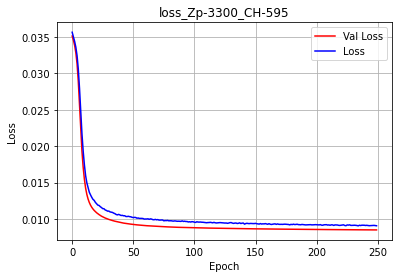

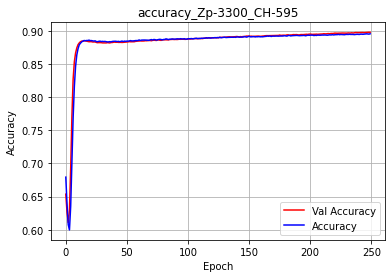

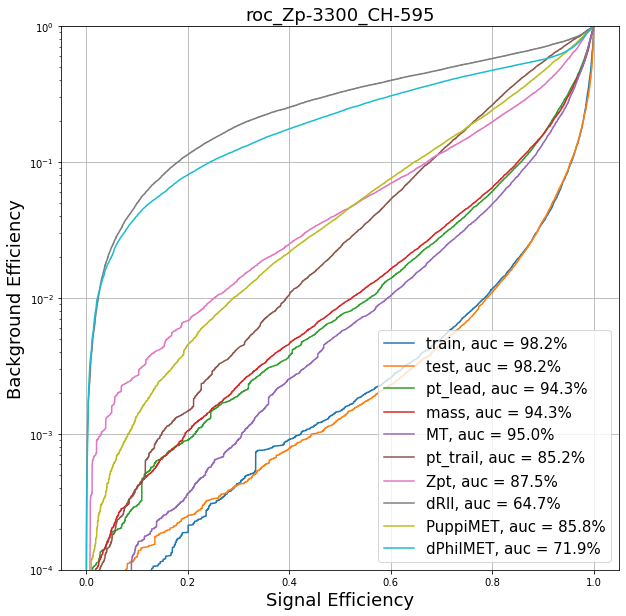

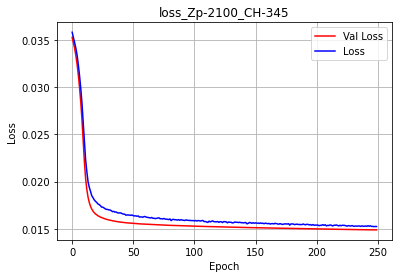

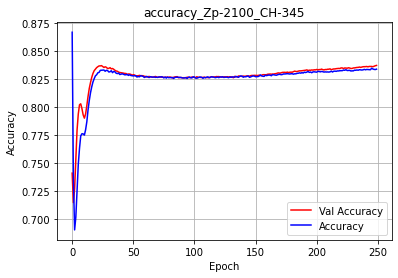

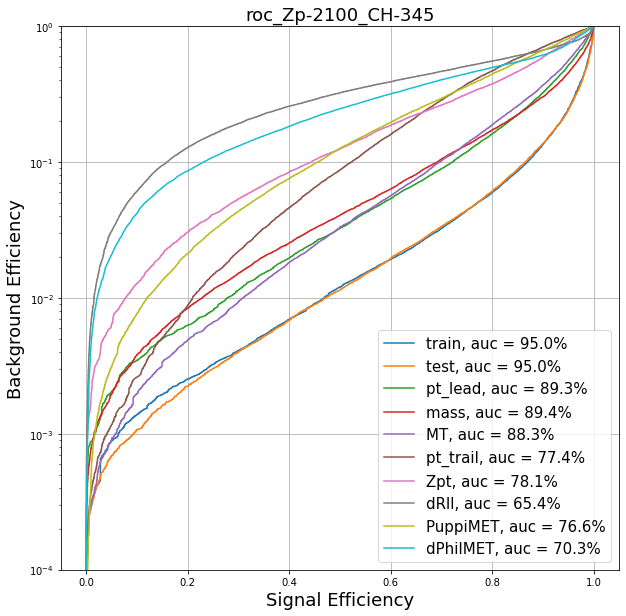

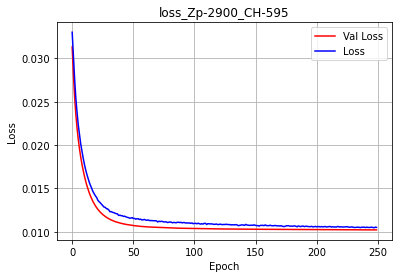

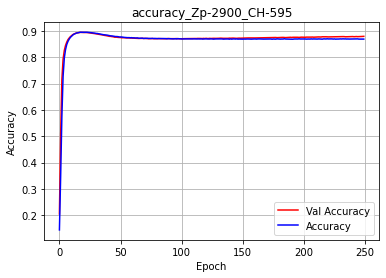

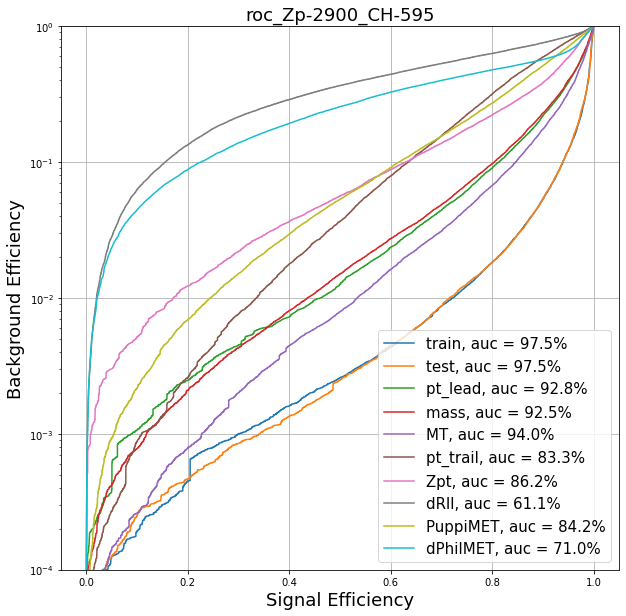

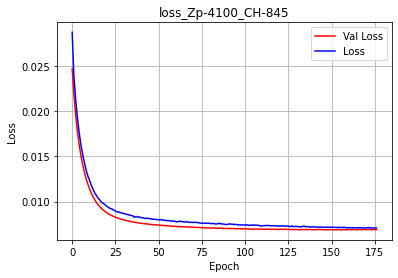

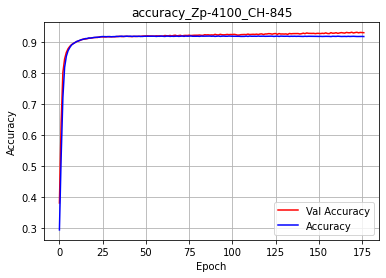

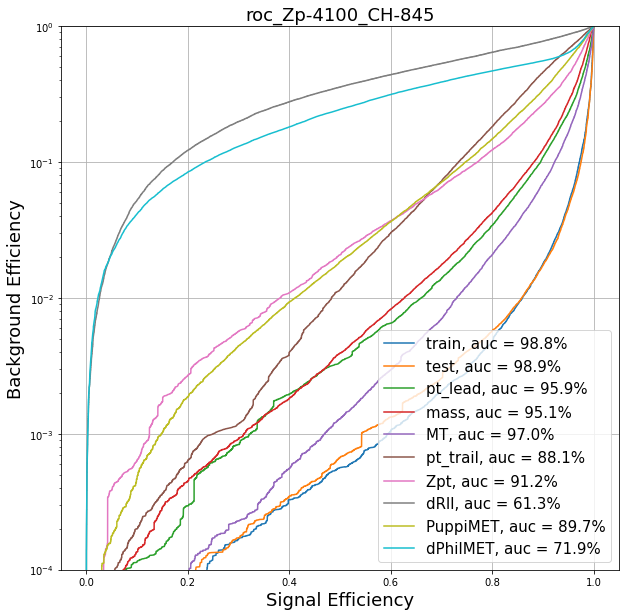

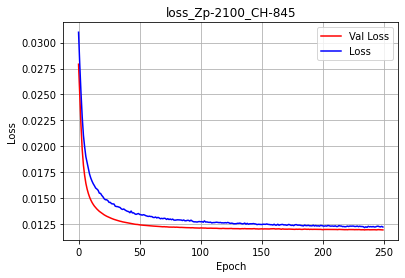

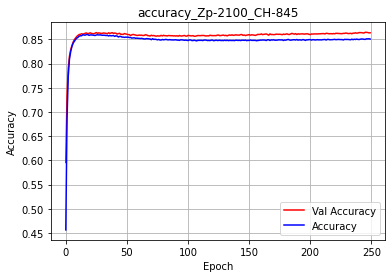

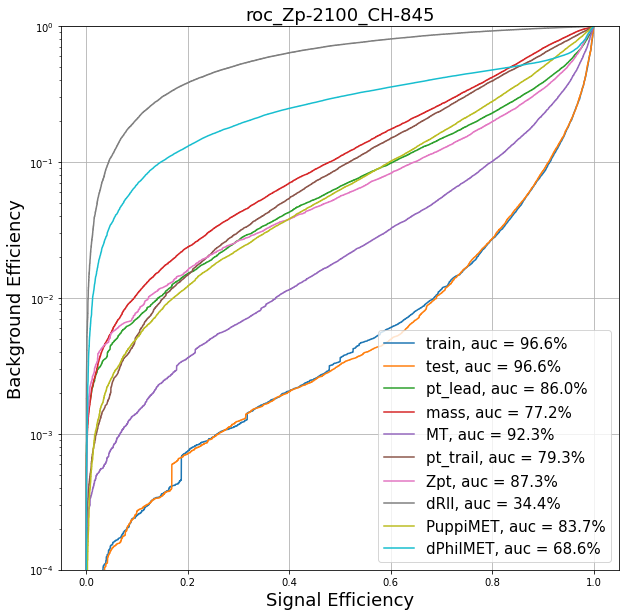

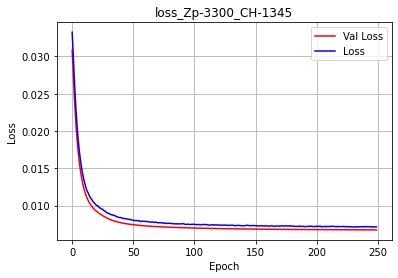

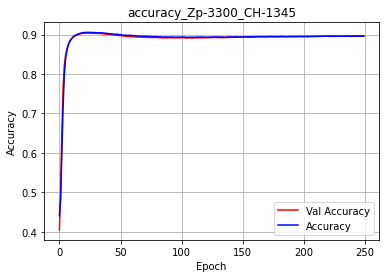

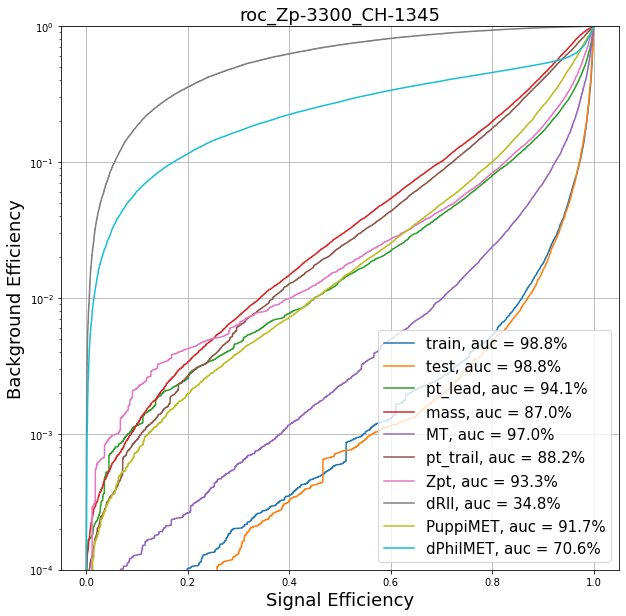

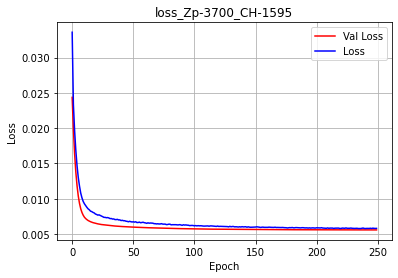

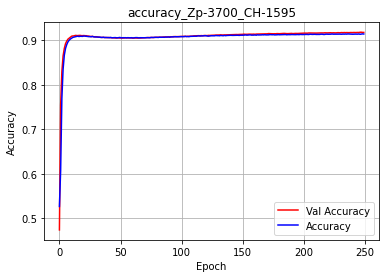

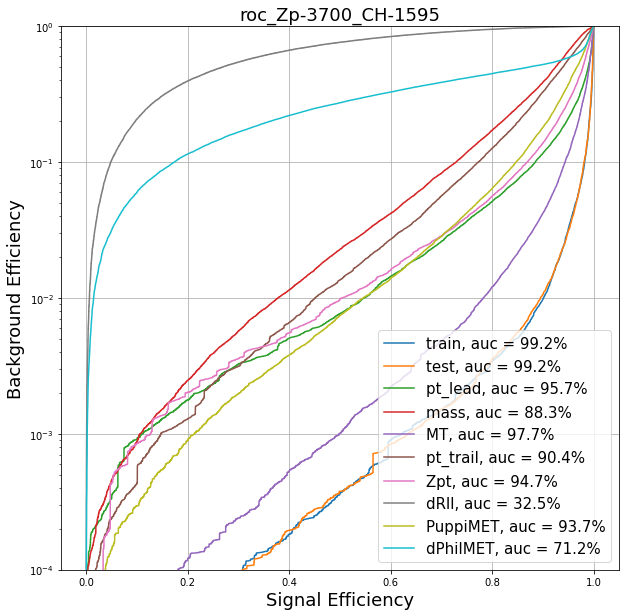

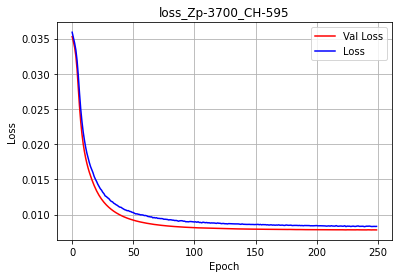

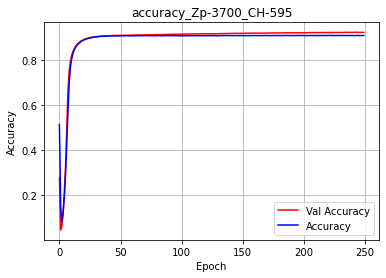

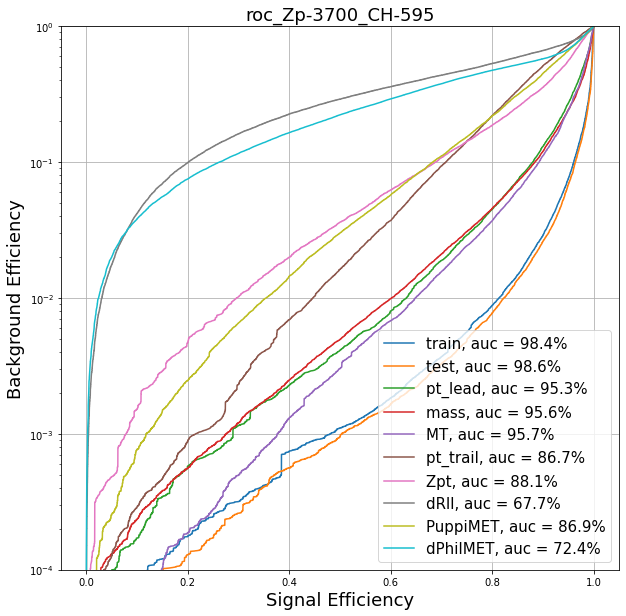

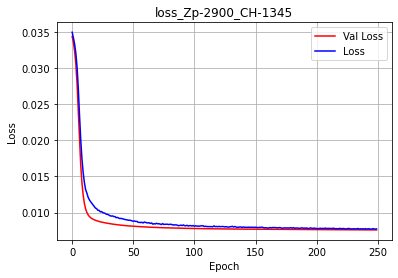

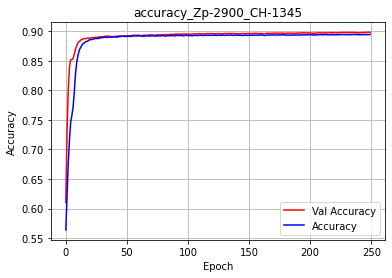

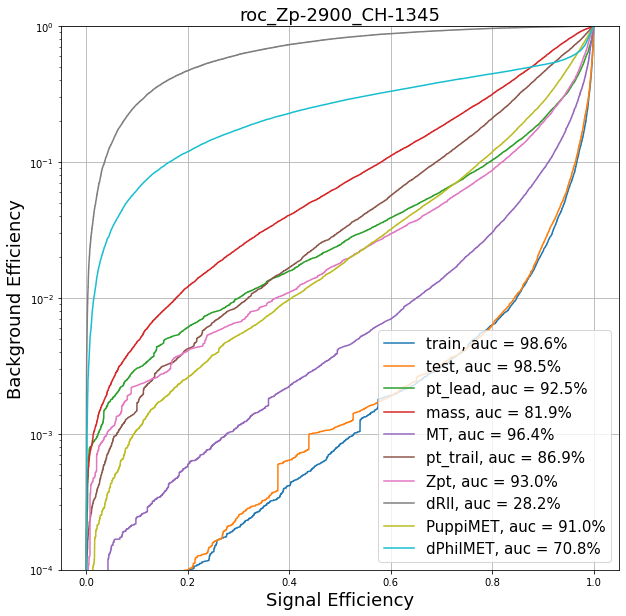

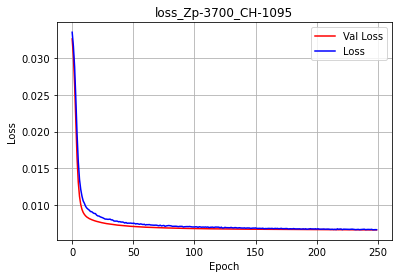

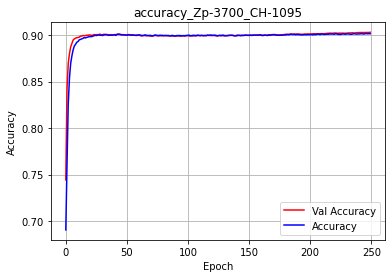

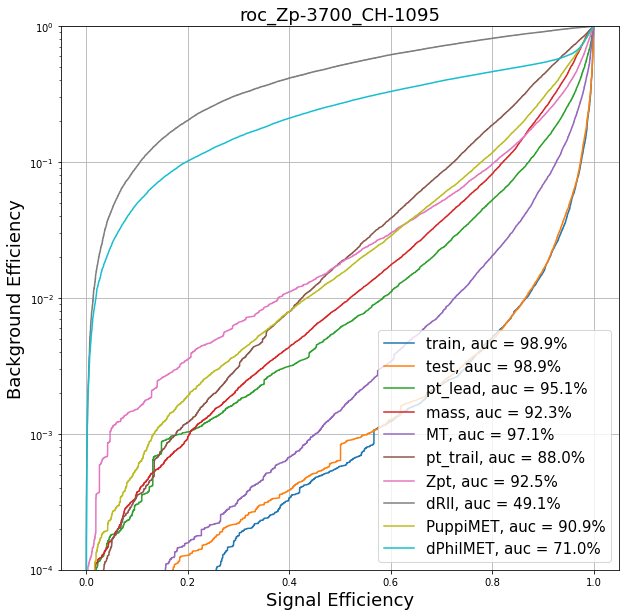

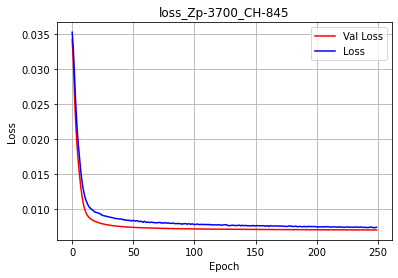

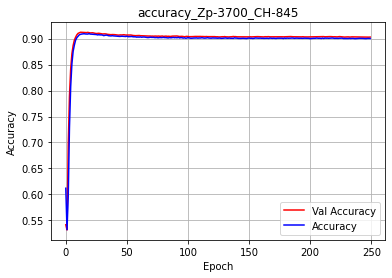

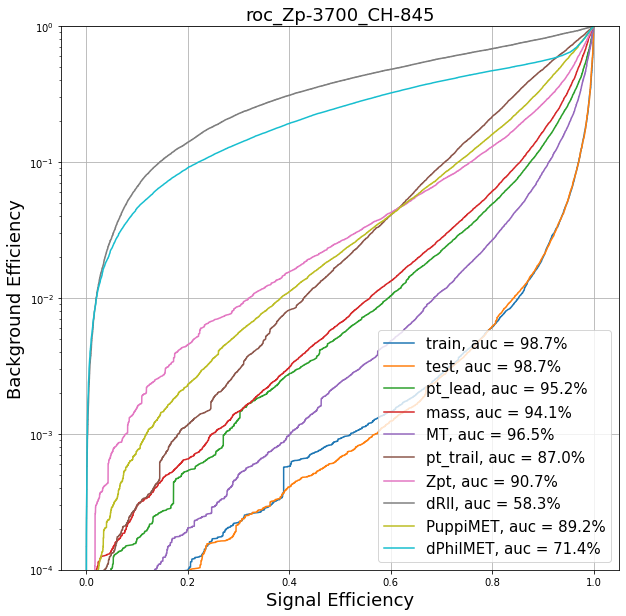

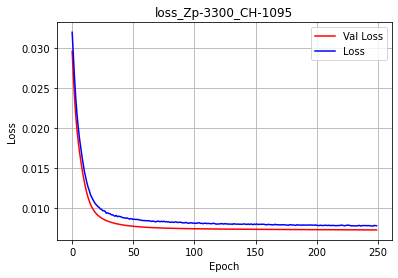

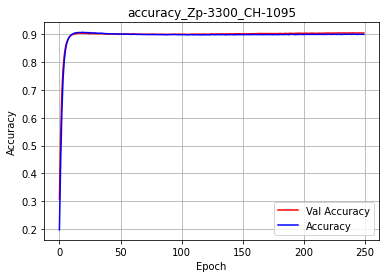

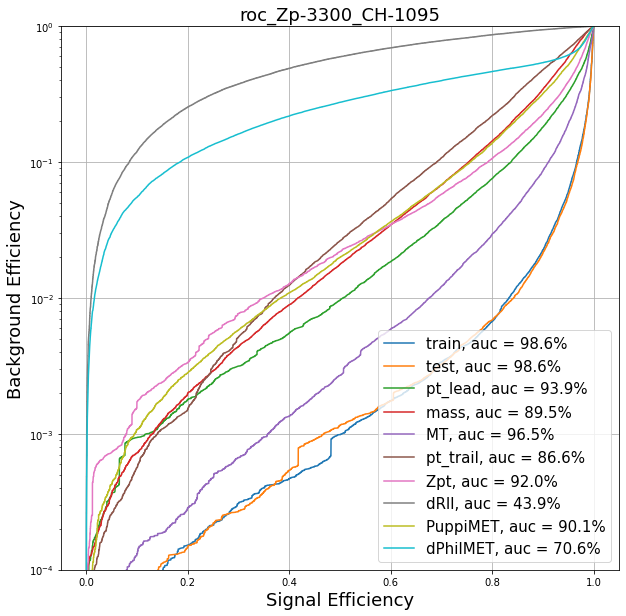

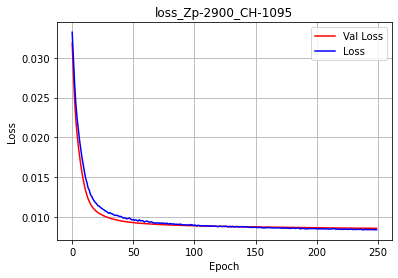

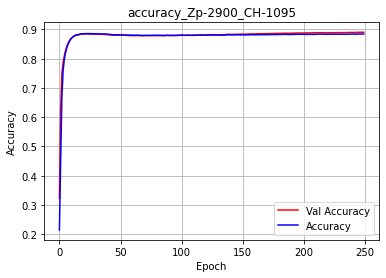

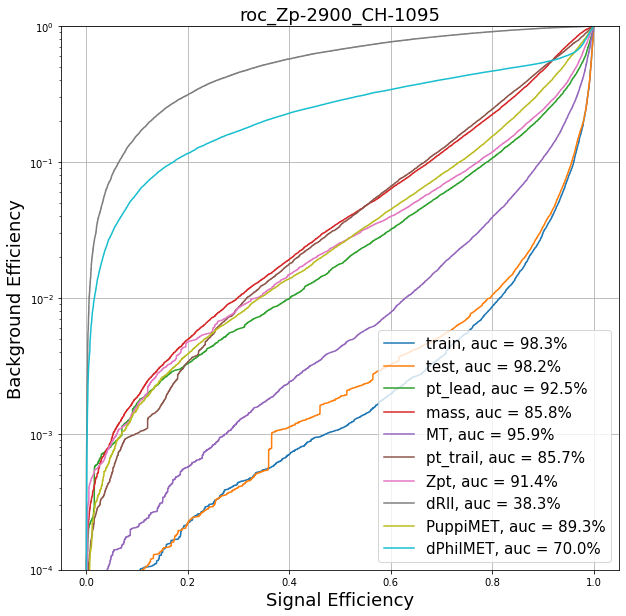

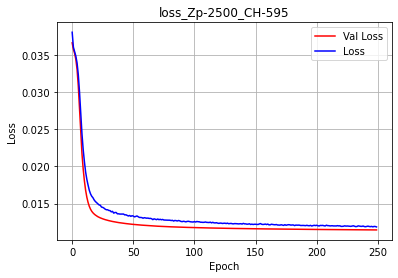

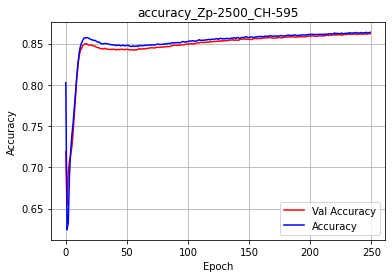

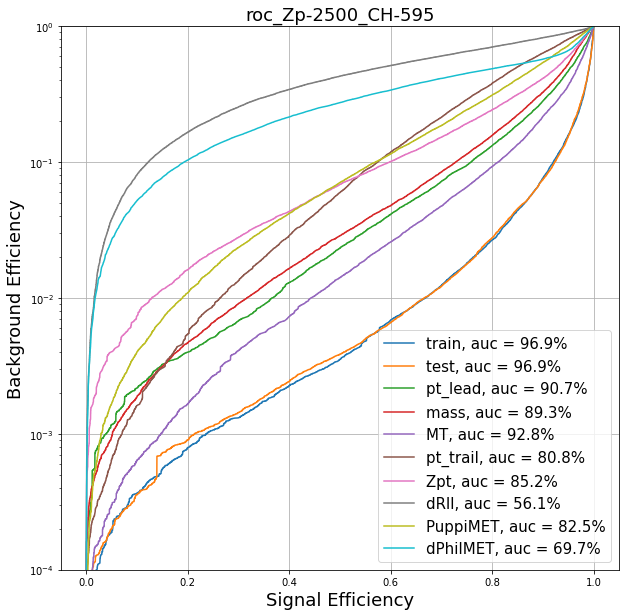

2023-03-27 23:55:00.449481: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Info in <TCanvas::Print>: pdf file Outputs/ee/Dedicated/check_withweight0_scorebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/ee/Dedicated/check_withweight0_score.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file Outputs/ee/Dedicated/check_withweight0_scorebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/ee/Dedicated/check_withweight0_score.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file Outputs/ee/Dedicated/check_withweight0_scorebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file Outputs/ee/Dedicated/check_withweight0_score.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canv

In [6]:
OUTDIR = 'Outputs/'+CHANNEL+'/Dedicated'
os.system('mkdir -p '+OUTDIR)

nbin=20

# model_masses = ['Zp-1700_CH-345', 'Zp-2500_CH-345', 'Zp-2900_CH-345', 'Zp-3300_CH-345', 'Zp-4100_CH-345']
model_masses = [m for m in dic_df_train if 'Zp' in m] # if want to run all
# model_masses = ['Zp-2500_CH-345']
model_masses = model_masses[19:] # temp
# %matplotlib inline
rt.gROOT.SetBatch(rt.kTRUE)

for model_mass in model_masses:
    
    file_postfix = model_mass+'_'+VERSION
    
    x, y, w, w_raw = get_binary(model_mass)

    # binalize
    lb = preprocessing.LabelBinarizer()
    lb.fit(y)
    lb.classes_
    y=lb.transform(y)

    # split train, test
    x_train, x_test, y_train, y_test, w_train, w_test, w_train_raw, w_test_raw = train_test_split(x, y, w, w_raw, test_size=0.5)

    # scale
    Transformer = preprocessing.StandardScaler()
    Transformer.fit(x)
    print('mean:',Transformer.mean_)
    print('var:',Transformer.var_)        
    x_train = Transformer.transform(x_train)
    x_test = Transformer.transform(x_test)
    pickle.dump(Transformer, open(OUTDIR+'/scaler_'+file_postfix+'.pkl','wb'))

    dic_df_scale={}
    for key2 in dic_df_train:
#             dic_df_scale[key2].append(dic_df_train[key2])       
        dic_df_scale[key2] = Transformer.transform(dic_df_train[key2])       
#     sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
    
    # training 
    epochs = 250
    batch = 512
    opt = keras.optimizers.SGD(learning_rate=0.01, decay=1e-6)
    early_stopping = keras.callbacks.EarlyStopping(patience=20)

    n_input = dic_df_train[key].shape[1]
    model = Seq(n_input, n_input, 1, tf.nn.sigmoid)
    model.compile(loss='binary_crossentropy', 
                  optimizer=opt, 
                  metrics=['accuracy'])

    log_dir = "logs/fit/mm_multiclass_" + time_stamp
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    dic_nested_roc = {}        
    dic_nested_soverb = {}        
    for i in range(1): # number of trials

        history = model.fit(x_train, y_train, verbose=1,
                         epochs=epochs, 
                         batch_size=batch,  
#                              class_weight={0:classweight_sig, 1:classweight_bkgs}, 
                         sample_weight=w_train,   
                         validation_data=(x_test,y_test,w_test), 
#                              validation_data=(x_test,y_test), 
                         callbacks=[early_stopping, tensorboard_callback])


        # evaluate
        TrainScore = model.evaluate(x_train, y_train, batch_size=x_train.shape[0], verbose=0)
        TestScore = model.evaluate(x_test, y_test, batch_size=x_test.shape[0], verbose=0)
        print('Train Loss :', TrainScore[0])
        print('Train Acc :', TrainScore[1])
        print('Test Loss :', TestScore[0])
        print('Test Acc :', TestScore[1])
        train_predict = model.predict(x_train, batch_size=x_train.shape[0])
        test_predict = model.predict(x_test, batch_size=x_test.shape[0])

        # save 
        model.save(OUTDIR+'/model_binary_'+file_postfix)
        with open(OUTDIR+'/history_binary_'+file_postfix, 'wb') as file_pi:
            pickle.dump(history.history, file_pi)        
        # loss
        pl2 = save_loss(model_mass, history, file_name=OUTDIR+'/loss_'+file_postfix+'.pdf')
        #pl2.show()
        #accuracy
        pl3 = save_accuracy(model_mass, history, file_name=OUTDIR+'/accuracy_'+file_postfix+'.pdf')
        #pl3.show()
        
        df_val = pd.DataFrame()
        df_val['y_test'] = y_test[:,0]
        df_val['test_predict'] = test_predict
        df_val['w_test_raw'] = w_test_raw
        df_tr = pd.DataFrame()
        df_tr['y_train'] = y_train[:,0]
        df_tr['train_predict'] = train_predict
        df_tr['w_train_raw'] = w_train_raw
        
        pl4, tpr, fpr, auc, tpr1, fpr1, auc1=save_roc(model_mass, df_val, df_tr, x_train, selected_columns, file_name=OUTDIR+'/roc_'+file_postfix+'.pdf')
        dic_roc = {}
        dic_roc['tpr'] = tpr
        dic_roc['fpr'] = fpr
        dic_roc['auc'] = auc
        dic_roc['auc_tr'] = auc1        
        sig_stat, sig_pval = ks_2samp(df_val.query('y_test==1')['test_predict'], df_tr.query('y_train==1')['train_predict'])
        bkg_stat, bkg_pval = ks_2samp(df_val.query('y_test==0')['test_predict'], df_tr.query('y_train==0')['train_predict'])
        dic_roc['sig_stat'] = sig_stat
        dic_roc['sig_pval'] = sig_pval
        dic_roc['bkg_stat'] = bkg_stat
        dic_roc['bkg_pval'] = bkg_pval        
        dic_nested_roc['trial_'+str(i)] = dic_roc

        # predict
        dic_predict={}
        for key3 in dic_df_scale:
            dic_predict[key3] = model.predict(dic_df_scale[key3], batch_size=dic_df_scale[key3].shape[0])

        dic_predict_sort={}
        for key4 in dic_predict:
            new_df = dic_df[key4].copy(deep=True).reset_index(drop='True')
            new_df['score'] = dic_predict[key4]            
            dic_predict_sort[key4] = new_df
        ERA = 'ee17'
        hist=HistStack(dic_predict_sort, 'score', 'weight', nbin, 0, 1)                         
        c1=hist.draw_hist(key, ERA, file_name=OUTDIR+'/check_withweight'+str(i))

        yields = hist.get_yields_by_bin()
        dic_soverb = {}
        s = yields[model_mass]
        b = yields['bkg']
        dic_soverb['s'] = np.array(s)
        dic_soverb['b'] = np.array(b)
        dic_soverb['soverb'] = np.array(s)/np.array(b)
        
        q = []
        for j in range(len(s)):
            if b[j]==0: #temp
                continue
            q_j = 2*((s[j]+b[j])*math.log((s[j]+b[j])/b[j])-s[j])
            q.append(q_j)
        sum_q = sum(q)    
        z = math.sqrt(sum_q) 
        dic_soverb['z'] = z
      
        dic_nested_soverb['trial_'+str(i)] = dic_soverb

    with open(OUTDIR+'/nested_dic_roc_trials'+file_postfix+'.pkl', 'wb') as f:
        pickle.dump(dic_nested_roc, f)  
    with open(OUTDIR+'/nested_dic_soverb_trials'+file_postfix+'.pkl', 'wb') as f:
        pickle.dump(dic_nested_soverb, f) 

           

In [7]:
dic_nested_soverb

{'trial_0': {'s': array([ 0.53006897,  0.44748597,  0.3674649 ,  0.36915935,  0.40391219,
          0.42645438,  0.39593955,  0.34259396,  0.33374195,  0.42240906,
          0.44976444,  0.39102608,  0.48580639,  0.57275184,  0.93013989,
          1.21316787,  1.88348666,  2.63990857,  4.53769485, 26.0190428 ]),
  'b': array([13975.70635971,  3238.51002358,  1425.30261648,   908.84486238,
           769.6609805 ,   641.19395008,   404.91404014,   298.88444341,
           266.70089761,   257.52115486,   228.98060958,   188.65528338,
           179.04374935,   163.04958105,   214.38540679,   247.74456714,
           229.59665736,   189.07999201,   150.12181798,   165.57957457]),
  'soverb': array([3.79278838e-05, 1.38176498e-04, 2.57815355e-04, 4.06185215e-04,
         5.24792343e-04, 6.65094209e-04, 9.77836058e-04, 1.14624220e-03,
         1.25137168e-03, 1.64028878e-03, 1.96420318e-03, 2.07270147e-03,
         2.71333903e-03, 3.51274646e-03, 4.33863433e-03, 4.89684953e-03,
         8.2